In [1]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [2]:
model_path = r''  # Insert path of the cpc model
dataset_path = r''  # Insert path of the test dataset that was created using the run_cpc.py script

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_256/models/epoch_45.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [3]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [4]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

  0%|          | 0/20293 [00:00<?, ?it/s]

# Fit GMM and calculate indices

In [5]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(2, 30))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

  0%|          | 0/28 [00:00<?, ?it/s]

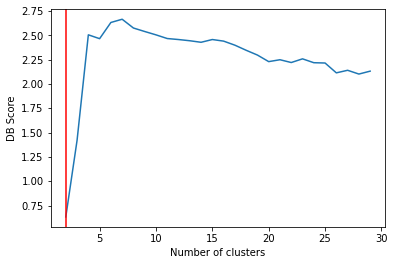

{0, 1}


In [6]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

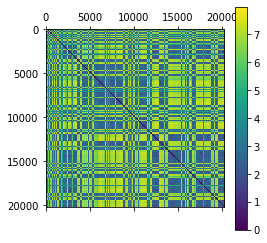

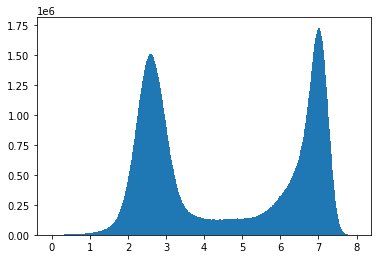

In [7]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

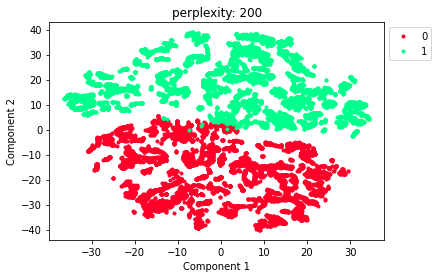

In [8]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [9]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [10]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [11]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [12]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 8

In [13]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.9781698122505298


In [14]:
losses = []
accs = []
sparsity = []

In [15]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.3878236377423898
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.7417127071823204
layer 3: 0.7417127071823204
layer 4: 0.6799033149171271
layer 5: 0.5253798342541436
layer 6: 0.41721339779005523
Epoch: 00 | Batch: 000 / 011 | Total loss: 0.700 | Reg loss: 0.015 | Tree loss: 0.700 | Accuracy: 0.608500 | 1.487 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 0.699 | Reg loss: 0.015 | Tree loss: 0.699 | Accuracy: 0.495000 | 0.861 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 0.693 | Reg loss: 0.014 | Tree loss: 0.693 | Accuracy: 0.529500 | 0.653 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 0.697 | Reg loss: 0.014 | Tree loss: 0.697 | Accuracy: 0.508500 | 0.548 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 0.692 | Reg loss: 0.014 | Tree loss: 0.692 | Accuracy: 0.534500 | 0.484 sec/iter
Epoch: 00 | Batch: 005 / 011 | Total loss: 0.683 | Reg loss: 0.014 | Tree loss: 0.683 | Accuracy: 0.599000 | 0.44 sec/iter
Epoch: 00 | Batch: 006 

layer 6: 0.9723756906077349
Epoch: 05 | Batch: 000 / 011 | Total loss: 0.692 | Reg loss: 0.012 | Tree loss: 0.692 | Accuracy: 0.531000 | 0.472 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 0.692 | Reg loss: 0.012 | Tree loss: 0.692 | Accuracy: 0.557000 | 0.467 sec/iter
Epoch: 05 | Batch: 002 / 011 | Total loss: 0.688 | Reg loss: 0.012 | Tree loss: 0.688 | Accuracy: 0.676500 | 0.463 sec/iter
Epoch: 05 | Batch: 003 / 011 | Total loss: 0.685 | Reg loss: 0.012 | Tree loss: 0.685 | Accuracy: 0.696000 | 0.459 sec/iter
Epoch: 05 | Batch: 004 / 011 | Total loss: 0.678 | Reg loss: 0.012 | Tree loss: 0.678 | Accuracy: 0.654500 | 0.455 sec/iter
Epoch: 05 | Batch: 005 / 011 | Total loss: 0.678 | Reg loss: 0.012 | Tree loss: 0.678 | Accuracy: 0.611500 | 0.451 sec/iter
Epoch: 05 | Batch: 006 / 011 | Total loss: 0.679 | Reg loss: 0.012 | Tree loss: 0.679 | Accuracy: 0.597000 | 0.447 sec/iter
Epoch: 05 | Batch: 007 / 011 | Total loss: 0.677 | Reg loss: 0.012 | Tree loss: 0.677 | Accuracy: 0.5990

Epoch: 10 | Batch: 002 / 011 | Total loss: 0.680 | Reg loss: 0.012 | Tree loss: 0.680 | Accuracy: 0.682000 | 0.445 sec/iter
Epoch: 10 | Batch: 003 / 011 | Total loss: 0.675 | Reg loss: 0.012 | Tree loss: 0.675 | Accuracy: 0.714500 | 0.443 sec/iter
Epoch: 10 | Batch: 004 / 011 | Total loss: 0.667 | Reg loss: 0.012 | Tree loss: 0.667 | Accuracy: 0.705500 | 0.441 sec/iter
Epoch: 10 | Batch: 005 / 011 | Total loss: 0.667 | Reg loss: 0.012 | Tree loss: 0.667 | Accuracy: 0.668000 | 0.439 sec/iter
Epoch: 10 | Batch: 006 / 011 | Total loss: 0.665 | Reg loss: 0.012 | Tree loss: 0.665 | Accuracy: 0.615000 | 0.438 sec/iter
Epoch: 10 | Batch: 007 / 011 | Total loss: 0.659 | Reg loss: 0.012 | Tree loss: 0.659 | Accuracy: 0.610500 | 0.436 sec/iter
Epoch: 10 | Batch: 008 / 011 | Total loss: 0.662 | Reg loss: 0.013 | Tree loss: 0.662 | Accuracy: 0.595500 | 0.434 sec/iter
Epoch: 10 | Batch: 009 / 011 | Total loss: 0.656 | Reg loss: 0.013 | Tree loss: 0.656 | Accuracy: 0.609000 | 0.432 sec/iter
Epoch: 1

Epoch: 15 | Batch: 004 / 011 | Total loss: 0.647 | Reg loss: 0.013 | Tree loss: 0.647 | Accuracy: 0.696000 | 0.432 sec/iter
Epoch: 15 | Batch: 005 / 011 | Total loss: 0.639 | Reg loss: 0.013 | Tree loss: 0.639 | Accuracy: 0.659000 | 0.431 sec/iter
Epoch: 15 | Batch: 006 / 011 | Total loss: 0.640 | Reg loss: 0.013 | Tree loss: 0.640 | Accuracy: 0.629500 | 0.43 sec/iter
Epoch: 15 | Batch: 007 / 011 | Total loss: 0.638 | Reg loss: 0.013 | Tree loss: 0.638 | Accuracy: 0.609000 | 0.429 sec/iter
Epoch: 15 | Batch: 008 / 011 | Total loss: 0.640 | Reg loss: 0.013 | Tree loss: 0.640 | Accuracy: 0.605000 | 0.428 sec/iter
Epoch: 15 | Batch: 009 / 011 | Total loss: 0.639 | Reg loss: 0.013 | Tree loss: 0.639 | Accuracy: 0.622000 | 0.426 sec/iter
Epoch: 15 | Batch: 010 / 011 | Total loss: 0.643 | Reg loss: 0.014 | Tree loss: 0.643 | Accuracy: 0.648464 | 0.425 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0

Epoch: 20 | Batch: 006 / 011 | Total loss: 0.604 | Reg loss: 0.014 | Tree loss: 0.604 | Accuracy: 0.669000 | 0.437 sec/iter
Epoch: 20 | Batch: 007 / 011 | Total loss: 0.607 | Reg loss: 0.014 | Tree loss: 0.607 | Accuracy: 0.690500 | 0.436 sec/iter
Epoch: 20 | Batch: 008 / 011 | Total loss: 0.599 | Reg loss: 0.014 | Tree loss: 0.599 | Accuracy: 0.755000 | 0.435 sec/iter
Epoch: 20 | Batch: 009 / 011 | Total loss: 0.600 | Reg loss: 0.014 | Tree loss: 0.600 | Accuracy: 0.764500 | 0.434 sec/iter
Epoch: 20 | Batch: 010 / 011 | Total loss: 0.596 | Reg loss: 0.014 | Tree loss: 0.596 | Accuracy: 0.771331 | 0.434 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 21 | Batch: 000 / 011 | Total loss: 0.644 | Reg loss: 0.014 | Tree loss: 0.644 | Accuracy: 0.695500 | 0.444 sec/iter
Epoch: 21 | Batch: 00

Epoch: 25 | Batch: 008 / 011 | Total loss: 0.565 | Reg loss: 0.015 | Tree loss: 0.565 | Accuracy: 0.802000 | 0.44 sec/iter
Epoch: 25 | Batch: 009 / 011 | Total loss: 0.575 | Reg loss: 0.015 | Tree loss: 0.575 | Accuracy: 0.802500 | 0.439 sec/iter
Epoch: 25 | Batch: 010 / 011 | Total loss: 0.554 | Reg loss: 0.015 | Tree loss: 0.554 | Accuracy: 0.836177 | 0.438 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 26 | Batch: 000 / 011 | Total loss: 0.628 | Reg loss: 0.015 | Tree loss: 0.628 | Accuracy: 0.680000 | 0.447 sec/iter
Epoch: 26 | Batch: 001 / 011 | Total loss: 0.606 | Reg loss: 0.015 | Tree loss: 0.606 | Accuracy: 0.723500 | 0.446 sec/iter
Epoch: 26 | Batch: 002 / 011 | Total loss: 0.593 | Reg loss: 0.015 | Tree loss: 0.593 | Accuracy: 0.725000 | 0.445 sec/iter
Epoch: 26 | Batch: 003

Epoch: 30 | Batch: 010 / 011 | Total loss: 0.532 | Reg loss: 0.015 | Tree loss: 0.532 | Accuracy: 0.812287 | 0.442 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 31 | Batch: 000 / 011 | Total loss: 0.617 | Reg loss: 0.015 | Tree loss: 0.617 | Accuracy: 0.685500 | 0.449 sec/iter
Epoch: 31 | Batch: 001 / 011 | Total loss: 0.594 | Reg loss: 0.015 | Tree loss: 0.594 | Accuracy: 0.717500 | 0.448 sec/iter
Epoch: 31 | Batch: 002 / 011 | Total loss: 0.578 | Reg loss: 0.015 | Tree loss: 0.578 | Accuracy: 0.739500 | 0.447 sec/iter
Epoch: 31 | Batch: 003 / 011 | Total loss: 0.565 | Reg loss: 0.015 | Tree loss: 0.565 | Accuracy: 0.724500 | 0.447 sec/iter
Epoch: 31 | Batch: 004 / 011 | Total loss: 0.569 | Reg loss: 0.015 | Tree loss: 0.569 | Accuracy: 0.697000 | 0.446 sec/iter
Epoch: 31 | Batch: 00

layer 6: 0.9723756906077349
Epoch: 36 | Batch: 000 / 011 | Total loss: 0.585 | Reg loss: 0.015 | Tree loss: 0.585 | Accuracy: 0.694000 | 0.441 sec/iter
Epoch: 36 | Batch: 001 / 011 | Total loss: 0.571 | Reg loss: 0.015 | Tree loss: 0.571 | Accuracy: 0.718000 | 0.44 sec/iter
Epoch: 36 | Batch: 002 / 011 | Total loss: 0.561 | Reg loss: 0.015 | Tree loss: 0.561 | Accuracy: 0.730000 | 0.44 sec/iter
Epoch: 36 | Batch: 003 / 011 | Total loss: 0.554 | Reg loss: 0.015 | Tree loss: 0.554 | Accuracy: 0.714000 | 0.439 sec/iter
Epoch: 36 | Batch: 004 / 011 | Total loss: 0.538 | Reg loss: 0.015 | Tree loss: 0.538 | Accuracy: 0.723500 | 0.439 sec/iter
Epoch: 36 | Batch: 005 / 011 | Total loss: 0.528 | Reg loss: 0.015 | Tree loss: 0.528 | Accuracy: 0.748500 | 0.438 sec/iter
Epoch: 36 | Batch: 006 / 011 | Total loss: 0.525 | Reg loss: 0.015 | Tree loss: 0.525 | Accuracy: 0.792000 | 0.438 sec/iter
Epoch: 36 | Batch: 007 / 011 | Total loss: 0.507 | Reg loss: 0.015 | Tree loss: 0.507 | Accuracy: 0.810000

Epoch: 41 | Batch: 002 / 011 | Total loss: 0.534 | Reg loss: 0.016 | Tree loss: 0.534 | Accuracy: 0.744500 | 0.442 sec/iter
Epoch: 41 | Batch: 003 / 011 | Total loss: 0.535 | Reg loss: 0.016 | Tree loss: 0.535 | Accuracy: 0.724000 | 0.442 sec/iter
Epoch: 41 | Batch: 004 / 011 | Total loss: 0.515 | Reg loss: 0.016 | Tree loss: 0.515 | Accuracy: 0.755000 | 0.441 sec/iter
Epoch: 41 | Batch: 005 / 011 | Total loss: 0.514 | Reg loss: 0.016 | Tree loss: 0.514 | Accuracy: 0.778500 | 0.441 sec/iter
Epoch: 41 | Batch: 006 / 011 | Total loss: 0.512 | Reg loss: 0.016 | Tree loss: 0.512 | Accuracy: 0.792000 | 0.44 sec/iter
Epoch: 41 | Batch: 007 / 011 | Total loss: 0.496 | Reg loss: 0.016 | Tree loss: 0.496 | Accuracy: 0.802500 | 0.44 sec/iter
Epoch: 41 | Batch: 008 / 011 | Total loss: 0.491 | Reg loss: 0.016 | Tree loss: 0.491 | Accuracy: 0.837500 | 0.439 sec/iter
Epoch: 41 | Batch: 009 / 011 | Total loss: 0.495 | Reg loss: 0.016 | Tree loss: 0.495 | Accuracy: 0.817500 | 0.439 sec/iter
Epoch: 41 

Epoch: 46 | Batch: 004 / 011 | Total loss: 0.522 | Reg loss: 0.016 | Tree loss: 0.522 | Accuracy: 0.723500 | 0.443 sec/iter
Epoch: 46 | Batch: 005 / 011 | Total loss: 0.508 | Reg loss: 0.016 | Tree loss: 0.508 | Accuracy: 0.771500 | 0.443 sec/iter
Epoch: 46 | Batch: 006 / 011 | Total loss: 0.492 | Reg loss: 0.016 | Tree loss: 0.492 | Accuracy: 0.797000 | 0.442 sec/iter
Epoch: 46 | Batch: 007 / 011 | Total loss: 0.469 | Reg loss: 0.016 | Tree loss: 0.469 | Accuracy: 0.824000 | 0.442 sec/iter
Epoch: 46 | Batch: 008 / 011 | Total loss: 0.490 | Reg loss: 0.016 | Tree loss: 0.490 | Accuracy: 0.782000 | 0.442 sec/iter
Epoch: 46 | Batch: 009 / 011 | Total loss: 0.483 | Reg loss: 0.016 | Tree loss: 0.483 | Accuracy: 0.844000 | 0.441 sec/iter
Epoch: 46 | Batch: 010 / 011 | Total loss: 0.482 | Reg loss: 0.016 | Tree loss: 0.482 | Accuracy: 0.822526 | 0.441 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 

Epoch: 51 | Batch: 006 / 011 | Total loss: 0.500 | Reg loss: 0.016 | Tree loss: 0.500 | Accuracy: 0.786000 | 0.444 sec/iter
Epoch: 51 | Batch: 007 / 011 | Total loss: 0.480 | Reg loss: 0.016 | Tree loss: 0.480 | Accuracy: 0.807000 | 0.444 sec/iter
Epoch: 51 | Batch: 008 / 011 | Total loss: 0.480 | Reg loss: 0.016 | Tree loss: 0.480 | Accuracy: 0.830000 | 0.443 sec/iter
Epoch: 51 | Batch: 009 / 011 | Total loss: 0.458 | Reg loss: 0.016 | Tree loss: 0.458 | Accuracy: 0.827000 | 0.443 sec/iter
Epoch: 51 | Batch: 010 / 011 | Total loss: 0.475 | Reg loss: 0.016 | Tree loss: 0.475 | Accuracy: 0.808874 | 0.443 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 52 | Batch: 000 / 011 | Total loss: 0.550 | Reg loss: 0.016 | Tree loss: 0.550 | Accuracy: 0.705500 | 0.447 sec/iter
Epoch: 52 | Batch: 00

Epoch: 56 | Batch: 008 / 011 | Total loss: 0.475 | Reg loss: 0.016 | Tree loss: 0.475 | Accuracy: 0.790000 | 0.435 sec/iter
Epoch: 56 | Batch: 009 / 011 | Total loss: 0.452 | Reg loss: 0.016 | Tree loss: 0.452 | Accuracy: 0.839000 | 0.435 sec/iter
Epoch: 56 | Batch: 010 / 011 | Total loss: 0.447 | Reg loss: 0.016 | Tree loss: 0.447 | Accuracy: 0.839590 | 0.434 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 57 | Batch: 000 / 011 | Total loss: 0.545 | Reg loss: 0.016 | Tree loss: 0.545 | Accuracy: 0.693000 | 0.438 sec/iter
Epoch: 57 | Batch: 001 / 011 | Total loss: 0.543 | Reg loss: 0.016 | Tree loss: 0.543 | Accuracy: 0.698500 | 0.438 sec/iter
Epoch: 57 | Batch: 002 / 011 | Total loss: 0.514 | Reg loss: 0.016 | Tree loss: 0.514 | Accuracy: 0.717000 | 0.438 sec/iter
Epoch: 57 | Batch: 00

Epoch: 61 | Batch: 010 / 011 | Total loss: 0.469 | Reg loss: 0.016 | Tree loss: 0.469 | Accuracy: 0.815700 | 0.437 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 62 | Batch: 000 / 011 | Total loss: 0.538 | Reg loss: 0.016 | Tree loss: 0.538 | Accuracy: 0.702500 | 0.44 sec/iter
Epoch: 62 | Batch: 001 / 011 | Total loss: 0.541 | Reg loss: 0.016 | Tree loss: 0.541 | Accuracy: 0.704500 | 0.44 sec/iter
Epoch: 62 | Batch: 002 / 011 | Total loss: 0.516 | Reg loss: 0.016 | Tree loss: 0.516 | Accuracy: 0.722000 | 0.439 sec/iter
Epoch: 62 | Batch: 003 / 011 | Total loss: 0.491 | Reg loss: 0.016 | Tree loss: 0.491 | Accuracy: 0.767000 | 0.439 sec/iter
Epoch: 62 | Batch: 004 / 011 | Total loss: 0.483 | Reg loss: 0.016 | Tree loss: 0.483 | Accuracy: 0.799000 | 0.439 sec/iter
Epoch: 62 | Batch: 005 

layer 6: 0.9723756906077349
Epoch: 67 | Batch: 000 / 011 | Total loss: 0.536 | Reg loss: 0.016 | Tree loss: 0.536 | Accuracy: 0.706500 | 0.442 sec/iter
Epoch: 67 | Batch: 001 / 011 | Total loss: 0.534 | Reg loss: 0.016 | Tree loss: 0.534 | Accuracy: 0.713000 | 0.442 sec/iter
Epoch: 67 | Batch: 002 / 011 | Total loss: 0.514 | Reg loss: 0.016 | Tree loss: 0.514 | Accuracy: 0.717000 | 0.441 sec/iter
Epoch: 67 | Batch: 003 / 011 | Total loss: 0.492 | Reg loss: 0.016 | Tree loss: 0.492 | Accuracy: 0.758500 | 0.441 sec/iter
Epoch: 67 | Batch: 004 / 011 | Total loss: 0.467 | Reg loss: 0.016 | Tree loss: 0.467 | Accuracy: 0.786500 | 0.441 sec/iter
Epoch: 67 | Batch: 005 / 011 | Total loss: 0.469 | Reg loss: 0.016 | Tree loss: 0.469 | Accuracy: 0.798500 | 0.44 sec/iter
Epoch: 67 | Batch: 006 / 011 | Total loss: 0.460 | Reg loss: 0.016 | Tree loss: 0.460 | Accuracy: 0.805500 | 0.44 sec/iter
Epoch: 67 | Batch: 007 / 011 | Total loss: 0.459 | Reg loss: 0.016 | Tree loss: 0.459 | Accuracy: 0.804500

Epoch: 72 | Batch: 002 / 011 | Total loss: 0.507 | Reg loss: 0.016 | Tree loss: 0.507 | Accuracy: 0.744500 | 0.443 sec/iter
Epoch: 72 | Batch: 003 / 011 | Total loss: 0.489 | Reg loss: 0.016 | Tree loss: 0.489 | Accuracy: 0.762000 | 0.443 sec/iter
Epoch: 72 | Batch: 004 / 011 | Total loss: 0.464 | Reg loss: 0.016 | Tree loss: 0.464 | Accuracy: 0.806500 | 0.442 sec/iter
Epoch: 72 | Batch: 005 / 011 | Total loss: 0.464 | Reg loss: 0.016 | Tree loss: 0.464 | Accuracy: 0.810000 | 0.442 sec/iter
Epoch: 72 | Batch: 006 / 011 | Total loss: 0.463 | Reg loss: 0.016 | Tree loss: 0.463 | Accuracy: 0.810500 | 0.442 sec/iter
Epoch: 72 | Batch: 007 / 011 | Total loss: 0.460 | Reg loss: 0.016 | Tree loss: 0.460 | Accuracy: 0.804500 | 0.442 sec/iter
Epoch: 72 | Batch: 008 / 011 | Total loss: 0.464 | Reg loss: 0.016 | Tree loss: 0.464 | Accuracy: 0.801500 | 0.441 sec/iter
Epoch: 72 | Batch: 009 / 011 | Total loss: 0.462 | Reg loss: 0.016 | Tree loss: 0.462 | Accuracy: 0.797000 | 0.441 sec/iter
Epoch: 7

Epoch: 77 | Batch: 004 / 011 | Total loss: 0.463 | Reg loss: 0.016 | Tree loss: 0.463 | Accuracy: 0.783000 | 0.44 sec/iter
Epoch: 77 | Batch: 005 / 011 | Total loss: 0.451 | Reg loss: 0.016 | Tree loss: 0.451 | Accuracy: 0.830000 | 0.44 sec/iter
Epoch: 77 | Batch: 006 / 011 | Total loss: 0.458 | Reg loss: 0.016 | Tree loss: 0.458 | Accuracy: 0.805000 | 0.44 sec/iter
Epoch: 77 | Batch: 007 / 011 | Total loss: 0.458 | Reg loss: 0.016 | Tree loss: 0.458 | Accuracy: 0.813000 | 0.44 sec/iter
Epoch: 77 | Batch: 008 / 011 | Total loss: 0.457 | Reg loss: 0.016 | Tree loss: 0.457 | Accuracy: 0.790000 | 0.439 sec/iter
Epoch: 77 | Batch: 009 / 011 | Total loss: 0.444 | Reg loss: 0.016 | Tree loss: 0.444 | Accuracy: 0.799000 | 0.439 sec/iter
Epoch: 77 | Batch: 010 / 011 | Total loss: 0.412 | Reg loss: 0.016 | Tree loss: 0.412 | Accuracy: 0.853242 | 0.439 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.97

Epoch: 82 | Batch: 006 / 011 | Total loss: 0.455 | Reg loss: 0.016 | Tree loss: 0.455 | Accuracy: 0.803500 | 0.433 sec/iter
Epoch: 82 | Batch: 007 / 011 | Total loss: 0.449 | Reg loss: 0.016 | Tree loss: 0.449 | Accuracy: 0.813500 | 0.433 sec/iter
Epoch: 82 | Batch: 008 / 011 | Total loss: 0.445 | Reg loss: 0.016 | Tree loss: 0.445 | Accuracy: 0.809500 | 0.433 sec/iter
Epoch: 82 | Batch: 009 / 011 | Total loss: 0.432 | Reg loss: 0.016 | Tree loss: 0.432 | Accuracy: 0.813500 | 0.432 sec/iter
Epoch: 82 | Batch: 010 / 011 | Total loss: 0.404 | Reg loss: 0.016 | Tree loss: 0.404 | Accuracy: 0.836177 | 0.432 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 83 | Batch: 000 / 011 | Total loss: 0.518 | Reg loss: 0.016 | Tree loss: 0.518 | Accuracy: 0.724500 | 0.435 sec/iter
Epoch: 83 | Batch: 00

Epoch: 87 | Batch: 008 / 011 | Total loss: 0.461 | Reg loss: 0.016 | Tree loss: 0.461 | Accuracy: 0.795000 | 0.434 sec/iter
Epoch: 87 | Batch: 009 / 011 | Total loss: 0.444 | Reg loss: 0.016 | Tree loss: 0.444 | Accuracy: 0.797500 | 0.434 sec/iter
Epoch: 87 | Batch: 010 / 011 | Total loss: 0.457 | Reg loss: 0.017 | Tree loss: 0.457 | Accuracy: 0.784983 | 0.434 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 88 | Batch: 000 / 011 | Total loss: 0.505 | Reg loss: 0.016 | Tree loss: 0.505 | Accuracy: 0.744000 | 0.437 sec/iter
Epoch: 88 | Batch: 001 / 011 | Total loss: 0.523 | Reg loss: 0.016 | Tree loss: 0.523 | Accuracy: 0.724000 | 0.436 sec/iter
Epoch: 88 | Batch: 002 / 011 | Total loss: 0.481 | Reg loss: 0.016 | Tree loss: 0.481 | Accuracy: 0.759000 | 0.436 sec/iter
Epoch: 88 | Batch: 00

Epoch: 92 | Batch: 010 / 011 | Total loss: 0.419 | Reg loss: 0.017 | Tree loss: 0.419 | Accuracy: 0.839590 | 0.436 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 93 | Batch: 000 / 011 | Total loss: 0.516 | Reg loss: 0.017 | Tree loss: 0.516 | Accuracy: 0.741500 | 0.438 sec/iter
Epoch: 93 | Batch: 001 / 011 | Total loss: 0.498 | Reg loss: 0.017 | Tree loss: 0.498 | Accuracy: 0.739500 | 0.438 sec/iter
Epoch: 93 | Batch: 002 / 011 | Total loss: 0.483 | Reg loss: 0.017 | Tree loss: 0.483 | Accuracy: 0.772000 | 0.438 sec/iter
Epoch: 93 | Batch: 003 / 011 | Total loss: 0.451 | Reg loss: 0.017 | Tree loss: 0.451 | Accuracy: 0.793000 | 0.437 sec/iter
Epoch: 93 | Batch: 004 / 011 | Total loss: 0.442 | Reg loss: 0.017 | Tree loss: 0.442 | Accuracy: 0.806000 | 0.437 sec/iter
Epoch: 93 | Batch: 00

layer 6: 0.9723756906077349
Epoch: 98 | Batch: 000 / 011 | Total loss: 0.497 | Reg loss: 0.017 | Tree loss: 0.497 | Accuracy: 0.748000 | 0.44 sec/iter
Epoch: 98 | Batch: 001 / 011 | Total loss: 0.485 | Reg loss: 0.017 | Tree loss: 0.485 | Accuracy: 0.763500 | 0.439 sec/iter
Epoch: 98 | Batch: 002 / 011 | Total loss: 0.473 | Reg loss: 0.017 | Tree loss: 0.473 | Accuracy: 0.753500 | 0.439 sec/iter
Epoch: 98 | Batch: 003 / 011 | Total loss: 0.475 | Reg loss: 0.017 | Tree loss: 0.475 | Accuracy: 0.786000 | 0.439 sec/iter
Epoch: 98 | Batch: 004 / 011 | Total loss: 0.456 | Reg loss: 0.017 | Tree loss: 0.456 | Accuracy: 0.788000 | 0.439 sec/iter
Epoch: 98 | Batch: 005 / 011 | Total loss: 0.412 | Reg loss: 0.017 | Tree loss: 0.412 | Accuracy: 0.834000 | 0.439 sec/iter
Epoch: 98 | Batch: 006 / 011 | Total loss: 0.430 | Reg loss: 0.017 | Tree loss: 0.430 | Accuracy: 0.818000 | 0.438 sec/iter
Epoch: 98 | Batch: 007 / 011 | Total loss: 0.442 | Reg loss: 0.017 | Tree loss: 0.442 | Accuracy: 0.80250

Epoch: 103 | Batch: 002 / 011 | Total loss: 0.488 | Reg loss: 0.017 | Tree loss: 0.488 | Accuracy: 0.756000 | 0.435 sec/iter
Epoch: 103 | Batch: 003 / 011 | Total loss: 0.459 | Reg loss: 0.017 | Tree loss: 0.459 | Accuracy: 0.776000 | 0.435 sec/iter
Epoch: 103 | Batch: 004 / 011 | Total loss: 0.427 | Reg loss: 0.017 | Tree loss: 0.427 | Accuracy: 0.826500 | 0.434 sec/iter
Epoch: 103 | Batch: 005 / 011 | Total loss: 0.412 | Reg loss: 0.017 | Tree loss: 0.412 | Accuracy: 0.832000 | 0.434 sec/iter
Epoch: 103 | Batch: 006 / 011 | Total loss: 0.428 | Reg loss: 0.017 | Tree loss: 0.428 | Accuracy: 0.824500 | 0.434 sec/iter
Epoch: 103 | Batch: 007 / 011 | Total loss: 0.434 | Reg loss: 0.017 | Tree loss: 0.434 | Accuracy: 0.797500 | 0.434 sec/iter
Epoch: 103 | Batch: 008 / 011 | Total loss: 0.416 | Reg loss: 0.017 | Tree loss: 0.416 | Accuracy: 0.813000 | 0.434 sec/iter
Epoch: 103 | Batch: 009 / 011 | Total loss: 0.427 | Reg loss: 0.017 | Tree loss: 0.427 | Accuracy: 0.805500 | 0.434 sec/iter


Epoch: 108 | Batch: 004 / 011 | Total loss: 0.430 | Reg loss: 0.017 | Tree loss: 0.430 | Accuracy: 0.818500 | 0.436 sec/iter
Epoch: 108 | Batch: 005 / 011 | Total loss: 0.438 | Reg loss: 0.017 | Tree loss: 0.438 | Accuracy: 0.810000 | 0.436 sec/iter
Epoch: 108 | Batch: 006 / 011 | Total loss: 0.431 | Reg loss: 0.017 | Tree loss: 0.431 | Accuracy: 0.828000 | 0.435 sec/iter
Epoch: 108 | Batch: 007 / 011 | Total loss: 0.425 | Reg loss: 0.017 | Tree loss: 0.425 | Accuracy: 0.811000 | 0.435 sec/iter
Epoch: 108 | Batch: 008 / 011 | Total loss: 0.453 | Reg loss: 0.017 | Tree loss: 0.453 | Accuracy: 0.790000 | 0.435 sec/iter
Epoch: 108 | Batch: 009 / 011 | Total loss: 0.428 | Reg loss: 0.017 | Tree loss: 0.428 | Accuracy: 0.805000 | 0.435 sec/iter
Epoch: 108 | Batch: 010 / 011 | Total loss: 0.400 | Reg loss: 0.017 | Tree loss: 0.400 | Accuracy: 0.863481 | 0.435 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 113 | Batch: 006 / 011 | Total loss: 0.432 | Reg loss: 0.017 | Tree loss: 0.432 | Accuracy: 0.826000 | 0.437 sec/iter
Epoch: 113 | Batch: 007 / 011 | Total loss: 0.421 | Reg loss: 0.017 | Tree loss: 0.421 | Accuracy: 0.814500 | 0.437 sec/iter
Epoch: 113 | Batch: 008 / 011 | Total loss: 0.423 | Reg loss: 0.017 | Tree loss: 0.423 | Accuracy: 0.811000 | 0.436 sec/iter
Epoch: 113 | Batch: 009 / 011 | Total loss: 0.410 | Reg loss: 0.017 | Tree loss: 0.410 | Accuracy: 0.818000 | 0.436 sec/iter
Epoch: 113 | Batch: 010 / 011 | Total loss: 0.402 | Reg loss: 0.017 | Tree loss: 0.402 | Accuracy: 0.836177 | 0.436 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 114 | Batch: 000 / 011 | Total loss: 0.480 | Reg loss: 0.017 | Tree loss: 0.480 | Accuracy: 0.761500 | 0.438 sec/iter
Epoch: 114 | Ba

Epoch: 118 | Batch: 008 / 011 | Total loss: 0.422 | Reg loss: 0.017 | Tree loss: 0.422 | Accuracy: 0.812000 | 0.438 sec/iter
Epoch: 118 | Batch: 009 / 011 | Total loss: 0.419 | Reg loss: 0.017 | Tree loss: 0.419 | Accuracy: 0.805000 | 0.437 sec/iter
Epoch: 118 | Batch: 010 / 011 | Total loss: 0.410 | Reg loss: 0.017 | Tree loss: 0.410 | Accuracy: 0.863481 | 0.437 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 119 | Batch: 000 / 011 | Total loss: 0.476 | Reg loss: 0.017 | Tree loss: 0.476 | Accuracy: 0.766500 | 0.439 sec/iter
Epoch: 119 | Batch: 001 / 011 | Total loss: 0.486 | Reg loss: 0.017 | Tree loss: 0.486 | Accuracy: 0.747000 | 0.439 sec/iter
Epoch: 119 | Batch: 002 / 011 | Total loss: 0.469 | Reg loss: 0.017 | Tree loss: 0.469 | Accuracy: 0.770000 | 0.439 sec/iter
Epoch: 119 | Ba

Epoch: 123 | Batch: 010 / 011 | Total loss: 0.452 | Reg loss: 0.017 | Tree loss: 0.452 | Accuracy: 0.791809 | 0.436 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 124 | Batch: 000 / 011 | Total loss: 0.476 | Reg loss: 0.017 | Tree loss: 0.476 | Accuracy: 0.759000 | 0.438 sec/iter
Epoch: 124 | Batch: 001 / 011 | Total loss: 0.474 | Reg loss: 0.017 | Tree loss: 0.474 | Accuracy: 0.751000 | 0.438 sec/iter
Epoch: 124 | Batch: 002 / 011 | Total loss: 0.464 | Reg loss: 0.017 | Tree loss: 0.464 | Accuracy: 0.781500 | 0.437 sec/iter
Epoch: 124 | Batch: 003 / 011 | Total loss: 0.446 | Reg loss: 0.017 | Tree loss: 0.446 | Accuracy: 0.799000 | 0.437 sec/iter
Epoch: 124 | Batch: 004 / 011 | Total loss: 0.430 | Reg loss: 0.017 | Tree loss: 0.430 | Accuracy: 0.811500 | 0.437 sec/iter
Epoch: 124 | Ba

layer 6: 0.9723756906077349
Epoch: 129 | Batch: 000 / 011 | Total loss: 0.477 | Reg loss: 0.017 | Tree loss: 0.477 | Accuracy: 0.767000 | 0.434 sec/iter
Epoch: 129 | Batch: 001 / 011 | Total loss: 0.460 | Reg loss: 0.017 | Tree loss: 0.460 | Accuracy: 0.765000 | 0.433 sec/iter
Epoch: 129 | Batch: 002 / 011 | Total loss: 0.442 | Reg loss: 0.017 | Tree loss: 0.442 | Accuracy: 0.801500 | 0.433 sec/iter
Epoch: 129 | Batch: 003 / 011 | Total loss: 0.425 | Reg loss: 0.017 | Tree loss: 0.425 | Accuracy: 0.806500 | 0.433 sec/iter
Epoch: 129 | Batch: 004 / 011 | Total loss: 0.418 | Reg loss: 0.017 | Tree loss: 0.418 | Accuracy: 0.820500 | 0.433 sec/iter
Epoch: 129 | Batch: 005 / 011 | Total loss: 0.418 | Reg loss: 0.017 | Tree loss: 0.418 | Accuracy: 0.836000 | 0.433 sec/iter
Epoch: 129 | Batch: 006 / 011 | Total loss: 0.434 | Reg loss: 0.017 | Tree loss: 0.434 | Accuracy: 0.814000 | 0.433 sec/iter
Epoch: 129 | Batch: 007 / 011 | Total loss: 0.427 | Reg loss: 0.017 | Tree loss: 0.427 | Accuracy

Epoch: 134 | Batch: 001 / 011 | Total loss: 0.454 | Reg loss: 0.017 | Tree loss: 0.454 | Accuracy: 0.768500 | 0.434 sec/iter
Epoch: 134 | Batch: 002 / 011 | Total loss: 0.444 | Reg loss: 0.017 | Tree loss: 0.444 | Accuracy: 0.800500 | 0.434 sec/iter
Epoch: 134 | Batch: 003 / 011 | Total loss: 0.422 | Reg loss: 0.017 | Tree loss: 0.422 | Accuracy: 0.817000 | 0.434 sec/iter
Epoch: 134 | Batch: 004 / 011 | Total loss: 0.429 | Reg loss: 0.017 | Tree loss: 0.429 | Accuracy: 0.813000 | 0.434 sec/iter
Epoch: 134 | Batch: 005 / 011 | Total loss: 0.436 | Reg loss: 0.017 | Tree loss: 0.436 | Accuracy: 0.815500 | 0.434 sec/iter
Epoch: 134 | Batch: 006 / 011 | Total loss: 0.406 | Reg loss: 0.017 | Tree loss: 0.406 | Accuracy: 0.828000 | 0.434 sec/iter
Epoch: 134 | Batch: 007 / 011 | Total loss: 0.427 | Reg loss: 0.017 | Tree loss: 0.427 | Accuracy: 0.799000 | 0.434 sec/iter
Epoch: 134 | Batch: 008 / 011 | Total loss: 0.395 | Reg loss: 0.017 | Tree loss: 0.395 | Accuracy: 0.832500 | 0.434 sec/iter


Epoch: 139 | Batch: 003 / 011 | Total loss: 0.430 | Reg loss: 0.017 | Tree loss: 0.430 | Accuracy: 0.803500 | 0.435 sec/iter
Epoch: 139 | Batch: 004 / 011 | Total loss: 0.406 | Reg loss: 0.017 | Tree loss: 0.406 | Accuracy: 0.837000 | 0.435 sec/iter
Epoch: 139 | Batch: 005 / 011 | Total loss: 0.412 | Reg loss: 0.017 | Tree loss: 0.412 | Accuracy: 0.827000 | 0.434 sec/iter
Epoch: 139 | Batch: 006 / 011 | Total loss: 0.420 | Reg loss: 0.017 | Tree loss: 0.420 | Accuracy: 0.822000 | 0.434 sec/iter
Epoch: 139 | Batch: 007 / 011 | Total loss: 0.414 | Reg loss: 0.017 | Tree loss: 0.414 | Accuracy: 0.816000 | 0.434 sec/iter
Epoch: 139 | Batch: 008 / 011 | Total loss: 0.411 | Reg loss: 0.017 | Tree loss: 0.411 | Accuracy: 0.821500 | 0.434 sec/iter
Epoch: 139 | Batch: 009 / 011 | Total loss: 0.414 | Reg loss: 0.017 | Tree loss: 0.414 | Accuracy: 0.842000 | 0.434 sec/iter
Epoch: 139 | Batch: 010 / 011 | Total loss: 0.389 | Reg loss: 0.017 | Tree loss: 0.389 | Accuracy: 0.836177 | 0.434 sec/iter


Epoch: 144 | Batch: 005 / 011 | Total loss: 0.387 | Reg loss: 0.017 | Tree loss: 0.387 | Accuracy: 0.845500 | 0.434 sec/iter
Epoch: 144 | Batch: 006 / 011 | Total loss: 0.405 | Reg loss: 0.017 | Tree loss: 0.405 | Accuracy: 0.829000 | 0.434 sec/iter
Epoch: 144 | Batch: 007 / 011 | Total loss: 0.410 | Reg loss: 0.017 | Tree loss: 0.410 | Accuracy: 0.826500 | 0.434 sec/iter
Epoch: 144 | Batch: 008 / 011 | Total loss: 0.395 | Reg loss: 0.017 | Tree loss: 0.395 | Accuracy: 0.818000 | 0.434 sec/iter
Epoch: 144 | Batch: 009 / 011 | Total loss: 0.415 | Reg loss: 0.017 | Tree loss: 0.415 | Accuracy: 0.818000 | 0.434 sec/iter
Epoch: 144 | Batch: 010 / 011 | Total loss: 0.408 | Reg loss: 0.017 | Tree loss: 0.408 | Accuracy: 0.819113 | 0.434 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 145 | Ba

Epoch: 149 | Batch: 007 / 011 | Total loss: 0.423 | Reg loss: 0.017 | Tree loss: 0.423 | Accuracy: 0.800000 | 0.431 sec/iter
Epoch: 149 | Batch: 008 / 011 | Total loss: 0.392 | Reg loss: 0.017 | Tree loss: 0.392 | Accuracy: 0.851000 | 0.431 sec/iter
Epoch: 149 | Batch: 009 / 011 | Total loss: 0.373 | Reg loss: 0.017 | Tree loss: 0.373 | Accuracy: 0.863500 | 0.431 sec/iter
Epoch: 149 | Batch: 010 / 011 | Total loss: 0.393 | Reg loss: 0.017 | Tree loss: 0.393 | Accuracy: 0.856655 | 0.431 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 150 | Batch: 000 / 011 | Total loss: 0.477 | Reg loss: 0.017 | Tree loss: 0.477 | Accuracy: 0.754500 | 0.431 sec/iter
Epoch: 150 | Batch: 001 / 011 | Total loss: 0.460 | Reg loss: 0.017 | Tree loss: 0.460 | Accuracy: 0.773000 | 0.431 sec/iter
Epoch: 150 | Ba

Epoch: 154 | Batch: 009 / 011 | Total loss: 0.391 | Reg loss: 0.017 | Tree loss: 0.391 | Accuracy: 0.861000 | 0.43 sec/iter
Epoch: 154 | Batch: 010 / 011 | Total loss: 0.427 | Reg loss: 0.017 | Tree loss: 0.427 | Accuracy: 0.877133 | 0.429 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 155 | Batch: 000 / 011 | Total loss: 0.451 | Reg loss: 0.017 | Tree loss: 0.451 | Accuracy: 0.776000 | 0.431 sec/iter
Epoch: 155 | Batch: 001 / 011 | Total loss: 0.470 | Reg loss: 0.017 | Tree loss: 0.470 | Accuracy: 0.766500 | 0.431 sec/iter
Epoch: 155 | Batch: 002 / 011 | Total loss: 0.427 | Reg loss: 0.017 | Tree loss: 0.427 | Accuracy: 0.801500 | 0.43 sec/iter
Epoch: 155 | Batch: 003 / 011 | Total loss: 0.413 | Reg loss: 0.017 | Tree loss: 0.413 | Accuracy: 0.819500 | 0.43 sec/iter
Epoch: 155 | Batch

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 160 | Batch: 000 / 011 | Total loss: 0.447 | Reg loss: 0.017 | Tree loss: 0.447 | Accuracy: 0.776500 | 0.431 sec/iter
Epoch: 160 | Batch: 001 / 011 | Total loss: 0.463 | Reg loss: 0.017 | Tree loss: 0.463 | Accuracy: 0.771000 | 0.431 sec/iter
Epoch: 160 | Batch: 002 / 011 | Total loss: 0.435 | Reg loss: 0.017 | Tree loss: 0.435 | Accuracy: 0.796000 | 0.43 sec/iter
Epoch: 160 | Batch: 003 / 011 | Total loss: 0.429 | Reg loss: 0.017 | Tree loss: 0.429 | Accuracy: 0.807000 | 0.43 sec/iter
Epoch: 160 | Batch: 004 / 011 | Total loss: 0.411 | Reg loss: 0.017 | Tree loss: 0.411 | Accuracy: 0.828000 | 0.43 sec/iter
Epoch: 160 | Batch: 005 / 011 | Total loss: 0.404 | Reg loss: 0.017 | Tree loss: 0.404 | Accuracy: 0.830500 | 0.43 sec/iter
Epoch: 160 | Batch:

layer 6: 0.9723756906077349
Epoch: 165 | Batch: 000 / 011 | Total loss: 0.470 | Reg loss: 0.017 | Tree loss: 0.470 | Accuracy: 0.768500 | 0.429 sec/iter
Epoch: 165 | Batch: 001 / 011 | Total loss: 0.443 | Reg loss: 0.017 | Tree loss: 0.443 | Accuracy: 0.783500 | 0.429 sec/iter
Epoch: 165 | Batch: 002 / 011 | Total loss: 0.415 | Reg loss: 0.017 | Tree loss: 0.415 | Accuracy: 0.814000 | 0.429 sec/iter
Epoch: 165 | Batch: 003 / 011 | Total loss: 0.424 | Reg loss: 0.017 | Tree loss: 0.424 | Accuracy: 0.810000 | 0.429 sec/iter
Epoch: 165 | Batch: 004 / 011 | Total loss: 0.412 | Reg loss: 0.017 | Tree loss: 0.412 | Accuracy: 0.821500 | 0.428 sec/iter
Epoch: 165 | Batch: 005 / 011 | Total loss: 0.413 | Reg loss: 0.017 | Tree loss: 0.413 | Accuracy: 0.820000 | 0.428 sec/iter
Epoch: 165 | Batch: 006 / 011 | Total loss: 0.424 | Reg loss: 0.017 | Tree loss: 0.424 | Accuracy: 0.800500 | 0.428 sec/iter
Epoch: 165 | Batch: 007 / 011 | Total loss: 0.391 | Reg loss: 0.017 | Tree loss: 0.391 | Accuracy

Epoch: 170 | Batch: 001 / 011 | Total loss: 0.468 | Reg loss: 0.017 | Tree loss: 0.468 | Accuracy: 0.771000 | 0.429 sec/iter
Epoch: 170 | Batch: 002 / 011 | Total loss: 0.431 | Reg loss: 0.017 | Tree loss: 0.431 | Accuracy: 0.797000 | 0.429 sec/iter
Epoch: 170 | Batch: 003 / 011 | Total loss: 0.417 | Reg loss: 0.017 | Tree loss: 0.417 | Accuracy: 0.818500 | 0.428 sec/iter
Epoch: 170 | Batch: 004 / 011 | Total loss: 0.402 | Reg loss: 0.017 | Tree loss: 0.402 | Accuracy: 0.830500 | 0.428 sec/iter
Epoch: 170 | Batch: 005 / 011 | Total loss: 0.409 | Reg loss: 0.017 | Tree loss: 0.409 | Accuracy: 0.810500 | 0.428 sec/iter
Epoch: 170 | Batch: 006 / 011 | Total loss: 0.410 | Reg loss: 0.017 | Tree loss: 0.410 | Accuracy: 0.804000 | 0.428 sec/iter
Epoch: 170 | Batch: 007 / 011 | Total loss: 0.405 | Reg loss: 0.017 | Tree loss: 0.405 | Accuracy: 0.815000 | 0.428 sec/iter
Epoch: 170 | Batch: 008 / 011 | Total loss: 0.400 | Reg loss: 0.017 | Tree loss: 0.400 | Accuracy: 0.851500 | 0.428 sec/iter


Epoch: 175 | Batch: 003 / 011 | Total loss: 0.412 | Reg loss: 0.017 | Tree loss: 0.412 | Accuracy: 0.817500 | 0.425 sec/iter
Epoch: 175 | Batch: 004 / 011 | Total loss: 0.400 | Reg loss: 0.017 | Tree loss: 0.400 | Accuracy: 0.848000 | 0.425 sec/iter
Epoch: 175 | Batch: 005 / 011 | Total loss: 0.417 | Reg loss: 0.017 | Tree loss: 0.417 | Accuracy: 0.809500 | 0.425 sec/iter
Epoch: 175 | Batch: 006 / 011 | Total loss: 0.406 | Reg loss: 0.017 | Tree loss: 0.406 | Accuracy: 0.813000 | 0.424 sec/iter
Epoch: 175 | Batch: 007 / 011 | Total loss: 0.412 | Reg loss: 0.017 | Tree loss: 0.412 | Accuracy: 0.829500 | 0.424 sec/iter
Epoch: 175 | Batch: 008 / 011 | Total loss: 0.394 | Reg loss: 0.017 | Tree loss: 0.394 | Accuracy: 0.840000 | 0.424 sec/iter
Epoch: 175 | Batch: 009 / 011 | Total loss: 0.399 | Reg loss: 0.017 | Tree loss: 0.399 | Accuracy: 0.865500 | 0.424 sec/iter
Epoch: 175 | Batch: 010 / 011 | Total loss: 0.424 | Reg loss: 0.017 | Tree loss: 0.424 | Accuracy: 0.832765 | 0.424 sec/iter


Epoch: 180 | Batch: 005 / 011 | Total loss: 0.400 | Reg loss: 0.017 | Tree loss: 0.400 | Accuracy: 0.833500 | 0.425 sec/iter
Epoch: 180 | Batch: 006 / 011 | Total loss: 0.400 | Reg loss: 0.017 | Tree loss: 0.400 | Accuracy: 0.813000 | 0.425 sec/iter
Epoch: 180 | Batch: 007 / 011 | Total loss: 0.408 | Reg loss: 0.017 | Tree loss: 0.408 | Accuracy: 0.833000 | 0.424 sec/iter
Epoch: 180 | Batch: 008 / 011 | Total loss: 0.393 | Reg loss: 0.017 | Tree loss: 0.393 | Accuracy: 0.847500 | 0.424 sec/iter
Epoch: 180 | Batch: 009 / 011 | Total loss: 0.405 | Reg loss: 0.017 | Tree loss: 0.405 | Accuracy: 0.846000 | 0.424 sec/iter
Epoch: 180 | Batch: 010 / 011 | Total loss: 0.393 | Reg loss: 0.017 | Tree loss: 0.393 | Accuracy: 0.877133 | 0.424 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 181 | Ba

Epoch: 185 | Batch: 007 / 011 | Total loss: 0.402 | Reg loss: 0.017 | Tree loss: 0.402 | Accuracy: 0.814500 | 0.425 sec/iter
Epoch: 185 | Batch: 008 / 011 | Total loss: 0.387 | Reg loss: 0.017 | Tree loss: 0.387 | Accuracy: 0.859500 | 0.425 sec/iter
Epoch: 185 | Batch: 009 / 011 | Total loss: 0.392 | Reg loss: 0.017 | Tree loss: 0.392 | Accuracy: 0.850000 | 0.424 sec/iter
Epoch: 185 | Batch: 010 / 011 | Total loss: 0.405 | Reg loss: 0.017 | Tree loss: 0.405 | Accuracy: 0.849829 | 0.424 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 186 | Batch: 000 / 011 | Total loss: 0.468 | Reg loss: 0.017 | Tree loss: 0.468 | Accuracy: 0.761000 | 0.425 sec/iter
Epoch: 186 | Batch: 001 / 011 | Total loss: 0.444 | Reg loss: 0.017 | Tree loss: 0.444 | Accuracy: 0.785500 | 0.425 sec/iter
Epoch: 186 | Ba

Epoch: 190 | Batch: 009 / 011 | Total loss: 0.398 | Reg loss: 0.017 | Tree loss: 0.398 | Accuracy: 0.848000 | 0.423 sec/iter
Epoch: 190 | Batch: 010 / 011 | Total loss: 0.393 | Reg loss: 0.017 | Tree loss: 0.393 | Accuracy: 0.839590 | 0.423 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 191 | Batch: 000 / 011 | Total loss: 0.447 | Reg loss: 0.017 | Tree loss: 0.447 | Accuracy: 0.780000 | 0.424 sec/iter
Epoch: 191 | Batch: 001 / 011 | Total loss: 0.446 | Reg loss: 0.017 | Tree loss: 0.446 | Accuracy: 0.780000 | 0.424 sec/iter
Epoch: 191 | Batch: 002 / 011 | Total loss: 0.437 | Reg loss: 0.017 | Tree loss: 0.437 | Accuracy: 0.801000 | 0.424 sec/iter
Epoch: 191 | Batch: 003 / 011 | Total loss: 0.436 | Reg loss: 0.017 | Tree loss: 0.436 | Accuracy: 0.793500 | 0.424 sec/iter
Epoch: 191 | Ba

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 196 | Batch: 000 / 011 | Total loss: 0.431 | Reg loss: 0.017 | Tree loss: 0.431 | Accuracy: 0.788000 | 0.424 sec/iter
Epoch: 196 | Batch: 001 / 011 | Total loss: 0.432 | Reg loss: 0.017 | Tree loss: 0.432 | Accuracy: 0.796000 | 0.424 sec/iter
Epoch: 196 | Batch: 002 / 011 | Total loss: 0.438 | Reg loss: 0.017 | Tree loss: 0.438 | Accuracy: 0.797500 | 0.423 sec/iter
Epoch: 196 | Batch: 003 / 011 | Total loss: 0.415 | Reg loss: 0.017 | Tree loss: 0.415 | Accuracy: 0.807000 | 0.423 sec/iter
Epoch: 196 | Batch: 004 / 011 | Total loss: 0.399 | Reg loss: 0.017 | Tree loss: 0.399 | Accuracy: 0.838000 | 0.423 sec/iter
Epoch: 196 | Batch: 005 / 011 | Total loss: 0.399 | Reg loss: 0.017 | Tree loss: 0.399 | Accuracy: 0.822000 | 0.423 sec/iter
Epoch: 196 | Ba

layer 6: 0.9723756906077349
Epoch: 201 | Batch: 000 / 011 | Total loss: 0.442 | Reg loss: 0.017 | Tree loss: 0.442 | Accuracy: 0.791000 | 0.423 sec/iter
Epoch: 201 | Batch: 001 / 011 | Total loss: 0.429 | Reg loss: 0.017 | Tree loss: 0.429 | Accuracy: 0.795000 | 0.423 sec/iter
Epoch: 201 | Batch: 002 / 011 | Total loss: 0.431 | Reg loss: 0.017 | Tree loss: 0.431 | Accuracy: 0.784000 | 0.423 sec/iter
Epoch: 201 | Batch: 003 / 011 | Total loss: 0.415 | Reg loss: 0.017 | Tree loss: 0.415 | Accuracy: 0.811000 | 0.423 sec/iter
Epoch: 201 | Batch: 004 / 011 | Total loss: 0.403 | Reg loss: 0.017 | Tree loss: 0.403 | Accuracy: 0.839000 | 0.423 sec/iter
Epoch: 201 | Batch: 005 / 011 | Total loss: 0.425 | Reg loss: 0.017 | Tree loss: 0.425 | Accuracy: 0.792000 | 0.422 sec/iter
Epoch: 201 | Batch: 006 / 011 | Total loss: 0.392 | Reg loss: 0.017 | Tree loss: 0.392 | Accuracy: 0.830000 | 0.422 sec/iter
Epoch: 201 | Batch: 007 / 011 | Total loss: 0.397 | Reg loss: 0.017 | Tree loss: 0.397 | Accuracy

Epoch: 206 | Batch: 001 / 011 | Total loss: 0.434 | Reg loss: 0.017 | Tree loss: 0.434 | Accuracy: 0.797500 | 0.423 sec/iter
Epoch: 206 | Batch: 002 / 011 | Total loss: 0.414 | Reg loss: 0.017 | Tree loss: 0.414 | Accuracy: 0.824000 | 0.423 sec/iter
Epoch: 206 | Batch: 003 / 011 | Total loss: 0.408 | Reg loss: 0.017 | Tree loss: 0.408 | Accuracy: 0.824500 | 0.423 sec/iter
Epoch: 206 | Batch: 004 / 011 | Total loss: 0.377 | Reg loss: 0.017 | Tree loss: 0.377 | Accuracy: 0.861000 | 0.423 sec/iter
Epoch: 206 | Batch: 005 / 011 | Total loss: 0.398 | Reg loss: 0.017 | Tree loss: 0.398 | Accuracy: 0.825000 | 0.423 sec/iter
Epoch: 206 | Batch: 006 / 011 | Total loss: 0.407 | Reg loss: 0.017 | Tree loss: 0.407 | Accuracy: 0.817500 | 0.423 sec/iter
Epoch: 206 | Batch: 007 / 011 | Total loss: 0.390 | Reg loss: 0.017 | Tree loss: 0.390 | Accuracy: 0.829500 | 0.423 sec/iter
Epoch: 206 | Batch: 008 / 011 | Total loss: 0.380 | Reg loss: 0.017 | Tree loss: 0.380 | Accuracy: 0.843500 | 0.423 sec/iter


Epoch: 211 | Batch: 003 / 011 | Total loss: 0.414 | Reg loss: 0.017 | Tree loss: 0.414 | Accuracy: 0.810500 | 0.422 sec/iter
Epoch: 211 | Batch: 004 / 011 | Total loss: 0.385 | Reg loss: 0.017 | Tree loss: 0.385 | Accuracy: 0.857000 | 0.422 sec/iter
Epoch: 211 | Batch: 005 / 011 | Total loss: 0.395 | Reg loss: 0.017 | Tree loss: 0.395 | Accuracy: 0.817000 | 0.422 sec/iter
Epoch: 211 | Batch: 006 / 011 | Total loss: 0.415 | Reg loss: 0.017 | Tree loss: 0.415 | Accuracy: 0.798500 | 0.422 sec/iter
Epoch: 211 | Batch: 007 / 011 | Total loss: 0.384 | Reg loss: 0.017 | Tree loss: 0.384 | Accuracy: 0.826500 | 0.422 sec/iter
Epoch: 211 | Batch: 008 / 011 | Total loss: 0.412 | Reg loss: 0.017 | Tree loss: 0.412 | Accuracy: 0.818000 | 0.422 sec/iter
Epoch: 211 | Batch: 009 / 011 | Total loss: 0.373 | Reg loss: 0.017 | Tree loss: 0.373 | Accuracy: 0.866500 | 0.421 sec/iter
Epoch: 211 | Batch: 010 / 011 | Total loss: 0.360 | Reg loss: 0.017 | Tree loss: 0.360 | Accuracy: 0.873720 | 0.421 sec/iter


Epoch: 216 | Batch: 005 / 011 | Total loss: 0.392 | Reg loss: 0.017 | Tree loss: 0.392 | Accuracy: 0.823500 | 0.422 sec/iter
Epoch: 216 | Batch: 006 / 011 | Total loss: 0.392 | Reg loss: 0.017 | Tree loss: 0.392 | Accuracy: 0.814000 | 0.422 sec/iter
Epoch: 216 | Batch: 007 / 011 | Total loss: 0.390 | Reg loss: 0.017 | Tree loss: 0.390 | Accuracy: 0.832000 | 0.422 sec/iter
Epoch: 216 | Batch: 008 / 011 | Total loss: 0.400 | Reg loss: 0.017 | Tree loss: 0.400 | Accuracy: 0.837000 | 0.422 sec/iter
Epoch: 216 | Batch: 009 / 011 | Total loss: 0.382 | Reg loss: 0.017 | Tree loss: 0.382 | Accuracy: 0.864000 | 0.422 sec/iter
Epoch: 216 | Batch: 010 / 011 | Total loss: 0.346 | Reg loss: 0.017 | Tree loss: 0.346 | Accuracy: 0.873720 | 0.422 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 217 | Ba

Epoch: 221 | Batch: 007 / 011 | Total loss: 0.400 | Reg loss: 0.017 | Tree loss: 0.400 | Accuracy: 0.823500 | 0.421 sec/iter
Epoch: 221 | Batch: 008 / 011 | Total loss: 0.385 | Reg loss: 0.017 | Tree loss: 0.385 | Accuracy: 0.850500 | 0.421 sec/iter
Epoch: 221 | Batch: 009 / 011 | Total loss: 0.389 | Reg loss: 0.017 | Tree loss: 0.389 | Accuracy: 0.850500 | 0.421 sec/iter
Epoch: 221 | Batch: 010 / 011 | Total loss: 0.400 | Reg loss: 0.017 | Tree loss: 0.400 | Accuracy: 0.901024 | 0.42 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 222 | Batch: 000 / 011 | Total loss: 0.458 | Reg loss: 0.017 | Tree loss: 0.458 | Accuracy: 0.786500 | 0.421 sec/iter
Epoch: 222 | Batch: 001 / 011 | Total loss: 0.421 | Reg loss: 0.017 | Tree loss: 0.421 | Accuracy: 0.815000 | 0.421 sec/iter
Epoch: 222 | Bat

Epoch: 226 | Batch: 009 / 011 | Total loss: 0.387 | Reg loss: 0.017 | Tree loss: 0.387 | Accuracy: 0.845500 | 0.421 sec/iter
Epoch: 226 | Batch: 010 / 011 | Total loss: 0.381 | Reg loss: 0.017 | Tree loss: 0.381 | Accuracy: 0.877133 | 0.421 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 227 | Batch: 000 / 011 | Total loss: 0.436 | Reg loss: 0.017 | Tree loss: 0.436 | Accuracy: 0.798000 | 0.422 sec/iter
Epoch: 227 | Batch: 001 / 011 | Total loss: 0.446 | Reg loss: 0.017 | Tree loss: 0.446 | Accuracy: 0.781000 | 0.422 sec/iter
Epoch: 227 | Batch: 002 / 011 | Total loss: 0.412 | Reg loss: 0.017 | Tree loss: 0.412 | Accuracy: 0.823500 | 0.422 sec/iter
Epoch: 227 | Batch: 003 / 011 | Total loss: 0.407 | Reg loss: 0.017 | Tree loss: 0.407 | Accuracy: 0.817000 | 0.422 sec/iter
Epoch: 227 | Ba

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 232 | Batch: 000 / 011 | Total loss: 0.444 | Reg loss: 0.016 | Tree loss: 0.444 | Accuracy: 0.801000 | 0.423 sec/iter
Epoch: 232 | Batch: 001 / 011 | Total loss: 0.402 | Reg loss: 0.016 | Tree loss: 0.402 | Accuracy: 0.819000 | 0.422 sec/iter
Epoch: 232 | Batch: 002 / 011 | Total loss: 0.411 | Reg loss: 0.016 | Tree loss: 0.411 | Accuracy: 0.824500 | 0.422 sec/iter
Epoch: 232 | Batch: 003 / 011 | Total loss: 0.398 | Reg loss: 0.017 | Tree loss: 0.398 | Accuracy: 0.838500 | 0.422 sec/iter
Epoch: 232 | Batch: 004 / 011 | Total loss: 0.399 | Reg loss: 0.017 | Tree loss: 0.399 | Accuracy: 0.832500 | 0.422 sec/iter
Epoch: 232 | Batch: 005 / 011 | Total loss: 0.384 | Reg loss: 0.017 | Tree loss: 0.384 | Accuracy: 0.825000 | 0.422 sec/iter
Epoch: 232 | Ba

layer 6: 0.9723756906077349
Epoch: 237 | Batch: 000 / 011 | Total loss: 0.433 | Reg loss: 0.016 | Tree loss: 0.433 | Accuracy: 0.801500 | 0.423 sec/iter
Epoch: 237 | Batch: 001 / 011 | Total loss: 0.421 | Reg loss: 0.016 | Tree loss: 0.421 | Accuracy: 0.812500 | 0.423 sec/iter
Epoch: 237 | Batch: 002 / 011 | Total loss: 0.415 | Reg loss: 0.016 | Tree loss: 0.415 | Accuracy: 0.815500 | 0.423 sec/iter
Epoch: 237 | Batch: 003 / 011 | Total loss: 0.402 | Reg loss: 0.016 | Tree loss: 0.402 | Accuracy: 0.827500 | 0.423 sec/iter
Epoch: 237 | Batch: 004 / 011 | Total loss: 0.388 | Reg loss: 0.016 | Tree loss: 0.388 | Accuracy: 0.853500 | 0.423 sec/iter
Epoch: 237 | Batch: 005 / 011 | Total loss: 0.391 | Reg loss: 0.016 | Tree loss: 0.391 | Accuracy: 0.817000 | 0.423 sec/iter
Epoch: 237 | Batch: 006 / 011 | Total loss: 0.410 | Reg loss: 0.016 | Tree loss: 0.410 | Accuracy: 0.815000 | 0.423 sec/iter
Epoch: 237 | Batch: 007 / 011 | Total loss: 0.394 | Reg loss: 0.016 | Tree loss: 0.394 | Accuracy

Epoch: 242 | Batch: 002 / 011 | Total loss: 0.406 | Reg loss: 0.016 | Tree loss: 0.406 | Accuracy: 0.827500 | 0.422 sec/iter
Epoch: 242 | Batch: 003 / 011 | Total loss: 0.389 | Reg loss: 0.016 | Tree loss: 0.389 | Accuracy: 0.824000 | 0.422 sec/iter
Epoch: 242 | Batch: 004 / 011 | Total loss: 0.397 | Reg loss: 0.016 | Tree loss: 0.397 | Accuracy: 0.848000 | 0.422 sec/iter
Epoch: 242 | Batch: 005 / 011 | Total loss: 0.403 | Reg loss: 0.016 | Tree loss: 0.403 | Accuracy: 0.808500 | 0.422 sec/iter
Epoch: 242 | Batch: 006 / 011 | Total loss: 0.389 | Reg loss: 0.016 | Tree loss: 0.389 | Accuracy: 0.821500 | 0.421 sec/iter
Epoch: 242 | Batch: 007 / 011 | Total loss: 0.410 | Reg loss: 0.016 | Tree loss: 0.410 | Accuracy: 0.810000 | 0.421 sec/iter
Epoch: 242 | Batch: 008 / 011 | Total loss: 0.377 | Reg loss: 0.016 | Tree loss: 0.377 | Accuracy: 0.849000 | 0.421 sec/iter
Epoch: 242 | Batch: 009 / 011 | Total loss: 0.373 | Reg loss: 0.016 | Tree loss: 0.373 | Accuracy: 0.865000 | 0.421 sec/iter


Epoch: 247 | Batch: 004 / 011 | Total loss: 0.404 | Reg loss: 0.016 | Tree loss: 0.404 | Accuracy: 0.828000 | 0.423 sec/iter
Epoch: 247 | Batch: 005 / 011 | Total loss: 0.392 | Reg loss: 0.016 | Tree loss: 0.392 | Accuracy: 0.819000 | 0.423 sec/iter
Epoch: 247 | Batch: 006 / 011 | Total loss: 0.409 | Reg loss: 0.016 | Tree loss: 0.409 | Accuracy: 0.797500 | 0.423 sec/iter
Epoch: 247 | Batch: 007 / 011 | Total loss: 0.398 | Reg loss: 0.016 | Tree loss: 0.398 | Accuracy: 0.818000 | 0.423 sec/iter
Epoch: 247 | Batch: 008 / 011 | Total loss: 0.365 | Reg loss: 0.016 | Tree loss: 0.365 | Accuracy: 0.853000 | 0.423 sec/iter
Epoch: 247 | Batch: 009 / 011 | Total loss: 0.382 | Reg loss: 0.016 | Tree loss: 0.382 | Accuracy: 0.860500 | 0.423 sec/iter
Epoch: 247 | Batch: 010 / 011 | Total loss: 0.399 | Reg loss: 0.016 | Tree loss: 0.399 | Accuracy: 0.853242 | 0.423 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 252 | Batch: 006 / 011 | Total loss: 0.386 | Reg loss: 0.016 | Tree loss: 0.386 | Accuracy: 0.818000 | 0.425 sec/iter
Epoch: 252 | Batch: 007 / 011 | Total loss: 0.395 | Reg loss: 0.016 | Tree loss: 0.395 | Accuracy: 0.826000 | 0.425 sec/iter
Epoch: 252 | Batch: 008 / 011 | Total loss: 0.376 | Reg loss: 0.016 | Tree loss: 0.376 | Accuracy: 0.853000 | 0.425 sec/iter
Epoch: 252 | Batch: 009 / 011 | Total loss: 0.378 | Reg loss: 0.016 | Tree loss: 0.378 | Accuracy: 0.855500 | 0.425 sec/iter
Epoch: 252 | Batch: 010 / 011 | Total loss: 0.373 | Reg loss: 0.016 | Tree loss: 0.373 | Accuracy: 0.870307 | 0.425 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 253 | Batch: 000 / 011 | Total loss: 0.420 | Reg loss: 0.016 | Tree loss: 0.420 | Accuracy: 0.812000 | 0.426 sec/iter
Epoch: 253 | Ba

Epoch: 257 | Batch: 008 / 011 | Total loss: 0.372 | Reg loss: 0.016 | Tree loss: 0.372 | Accuracy: 0.840000 | 0.428 sec/iter
Epoch: 257 | Batch: 009 / 011 | Total loss: 0.383 | Reg loss: 0.016 | Tree loss: 0.383 | Accuracy: 0.853500 | 0.428 sec/iter
Epoch: 257 | Batch: 010 / 011 | Total loss: 0.385 | Reg loss: 0.016 | Tree loss: 0.385 | Accuracy: 0.860068 | 0.428 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 258 | Batch: 000 / 011 | Total loss: 0.434 | Reg loss: 0.016 | Tree loss: 0.434 | Accuracy: 0.807000 | 0.429 sec/iter
Epoch: 258 | Batch: 001 / 011 | Total loss: 0.440 | Reg loss: 0.016 | Tree loss: 0.440 | Accuracy: 0.794000 | 0.429 sec/iter
Epoch: 258 | Batch: 002 / 011 | Total loss: 0.400 | Reg loss: 0.016 | Tree loss: 0.400 | Accuracy: 0.834000 | 0.429 sec/iter
Epoch: 258 | Ba

Epoch: 262 | Batch: 010 / 011 | Total loss: 0.369 | Reg loss: 0.016 | Tree loss: 0.369 | Accuracy: 0.846416 | 0.43 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 263 | Batch: 000 / 011 | Total loss: 0.445 | Reg loss: 0.016 | Tree loss: 0.445 | Accuracy: 0.799500 | 0.431 sec/iter
Epoch: 263 | Batch: 001 / 011 | Total loss: 0.426 | Reg loss: 0.016 | Tree loss: 0.426 | Accuracy: 0.814000 | 0.431 sec/iter
Epoch: 263 | Batch: 002 / 011 | Total loss: 0.432 | Reg loss: 0.016 | Tree loss: 0.432 | Accuracy: 0.805000 | 0.431 sec/iter
Epoch: 263 | Batch: 003 / 011 | Total loss: 0.392 | Reg loss: 0.016 | Tree loss: 0.392 | Accuracy: 0.824500 | 0.431 sec/iter
Epoch: 263 | Batch: 004 / 011 | Total loss: 0.377 | Reg loss: 0.016 | Tree loss: 0.377 | Accuracy: 0.858000 | 0.431 sec/iter
Epoch: 263 | Bat

layer 6: 0.9723756906077349
Epoch: 268 | Batch: 000 / 011 | Total loss: 0.428 | Reg loss: 0.016 | Tree loss: 0.428 | Accuracy: 0.810500 | 0.433 sec/iter
Epoch: 268 | Batch: 001 / 011 | Total loss: 0.430 | Reg loss: 0.016 | Tree loss: 0.430 | Accuracy: 0.800000 | 0.433 sec/iter
Epoch: 268 | Batch: 002 / 011 | Total loss: 0.418 | Reg loss: 0.016 | Tree loss: 0.418 | Accuracy: 0.812500 | 0.433 sec/iter
Epoch: 268 | Batch: 003 / 011 | Total loss: 0.385 | Reg loss: 0.016 | Tree loss: 0.385 | Accuracy: 0.826000 | 0.433 sec/iter
Epoch: 268 | Batch: 004 / 011 | Total loss: 0.377 | Reg loss: 0.016 | Tree loss: 0.377 | Accuracy: 0.851500 | 0.433 sec/iter
Epoch: 268 | Batch: 005 / 011 | Total loss: 0.403 | Reg loss: 0.016 | Tree loss: 0.403 | Accuracy: 0.812500 | 0.433 sec/iter
Epoch: 268 | Batch: 006 / 011 | Total loss: 0.393 | Reg loss: 0.016 | Tree loss: 0.393 | Accuracy: 0.822000 | 0.433 sec/iter
Epoch: 268 | Batch: 007 / 011 | Total loss: 0.394 | Reg loss: 0.016 | Tree loss: 0.394 | Accuracy

Epoch: 273 | Batch: 001 / 011 | Total loss: 0.432 | Reg loss: 0.016 | Tree loss: 0.432 | Accuracy: 0.809500 | 0.436 sec/iter
Epoch: 273 | Batch: 002 / 011 | Total loss: 0.419 | Reg loss: 0.016 | Tree loss: 0.419 | Accuracy: 0.820500 | 0.436 sec/iter
Epoch: 273 | Batch: 003 / 011 | Total loss: 0.384 | Reg loss: 0.016 | Tree loss: 0.384 | Accuracy: 0.841500 | 0.436 sec/iter
Epoch: 273 | Batch: 004 / 011 | Total loss: 0.368 | Reg loss: 0.016 | Tree loss: 0.368 | Accuracy: 0.868000 | 0.436 sec/iter
Epoch: 273 | Batch: 005 / 011 | Total loss: 0.392 | Reg loss: 0.016 | Tree loss: 0.392 | Accuracy: 0.821000 | 0.436 sec/iter
Epoch: 273 | Batch: 006 / 011 | Total loss: 0.382 | Reg loss: 0.016 | Tree loss: 0.382 | Accuracy: 0.826500 | 0.436 sec/iter
Epoch: 273 | Batch: 007 / 011 | Total loss: 0.399 | Reg loss: 0.016 | Tree loss: 0.399 | Accuracy: 0.811500 | 0.436 sec/iter
Epoch: 273 | Batch: 008 / 011 | Total loss: 0.387 | Reg loss: 0.016 | Tree loss: 0.387 | Accuracy: 0.823000 | 0.436 sec/iter


Epoch: 278 | Batch: 003 / 011 | Total loss: 0.397 | Reg loss: 0.016 | Tree loss: 0.397 | Accuracy: 0.819500 | 0.439 sec/iter
Epoch: 278 | Batch: 004 / 011 | Total loss: 0.376 | Reg loss: 0.016 | Tree loss: 0.376 | Accuracy: 0.866000 | 0.439 sec/iter
Epoch: 278 | Batch: 005 / 011 | Total loss: 0.388 | Reg loss: 0.016 | Tree loss: 0.388 | Accuracy: 0.821500 | 0.439 sec/iter
Epoch: 278 | Batch: 006 / 011 | Total loss: 0.386 | Reg loss: 0.016 | Tree loss: 0.386 | Accuracy: 0.827500 | 0.439 sec/iter
Epoch: 278 | Batch: 007 / 011 | Total loss: 0.396 | Reg loss: 0.016 | Tree loss: 0.396 | Accuracy: 0.812500 | 0.439 sec/iter
Epoch: 278 | Batch: 008 / 011 | Total loss: 0.388 | Reg loss: 0.016 | Tree loss: 0.388 | Accuracy: 0.820500 | 0.439 sec/iter
Epoch: 278 | Batch: 009 / 011 | Total loss: 0.387 | Reg loss: 0.016 | Tree loss: 0.387 | Accuracy: 0.837500 | 0.439 sec/iter
Epoch: 278 | Batch: 010 / 011 | Total loss: 0.352 | Reg loss: 0.016 | Tree loss: 0.352 | Accuracy: 0.866894 | 0.439 sec/iter


Epoch: 283 | Batch: 005 / 011 | Total loss: 0.393 | Reg loss: 0.016 | Tree loss: 0.393 | Accuracy: 0.816500 | 0.44 sec/iter
Epoch: 283 | Batch: 006 / 011 | Total loss: 0.393 | Reg loss: 0.016 | Tree loss: 0.393 | Accuracy: 0.827000 | 0.44 sec/iter
Epoch: 283 | Batch: 007 / 011 | Total loss: 0.379 | Reg loss: 0.016 | Tree loss: 0.379 | Accuracy: 0.828000 | 0.44 sec/iter
Epoch: 283 | Batch: 008 / 011 | Total loss: 0.397 | Reg loss: 0.016 | Tree loss: 0.397 | Accuracy: 0.812000 | 0.44 sec/iter
Epoch: 283 | Batch: 009 / 011 | Total loss: 0.371 | Reg loss: 0.016 | Tree loss: 0.371 | Accuracy: 0.848000 | 0.44 sec/iter
Epoch: 283 | Batch: 010 / 011 | Total loss: 0.394 | Reg loss: 0.016 | Tree loss: 0.394 | Accuracy: 0.849829 | 0.44 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 284 | Batch: 0

Epoch: 288 | Batch: 007 / 011 | Total loss: 0.389 | Reg loss: 0.016 | Tree loss: 0.389 | Accuracy: 0.811000 | 0.442 sec/iter
Epoch: 288 | Batch: 008 / 011 | Total loss: 0.386 | Reg loss: 0.016 | Tree loss: 0.386 | Accuracy: 0.838000 | 0.442 sec/iter
Epoch: 288 | Batch: 009 / 011 | Total loss: 0.371 | Reg loss: 0.016 | Tree loss: 0.371 | Accuracy: 0.872000 | 0.442 sec/iter
Epoch: 288 | Batch: 010 / 011 | Total loss: 0.370 | Reg loss: 0.016 | Tree loss: 0.370 | Accuracy: 0.880546 | 0.442 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 289 | Batch: 000 / 011 | Total loss: 0.432 | Reg loss: 0.016 | Tree loss: 0.432 | Accuracy: 0.806000 | 0.442 sec/iter
Epoch: 289 | Batch: 001 / 011 | Total loss: 0.425 | Reg loss: 0.016 | Tree loss: 0.425 | Accuracy: 0.813000 | 0.442 sec/iter
Epoch: 289 | Ba

Epoch: 293 | Batch: 009 / 011 | Total loss: 0.386 | Reg loss: 0.016 | Tree loss: 0.386 | Accuracy: 0.845000 | 0.443 sec/iter
Epoch: 293 | Batch: 010 / 011 | Total loss: 0.372 | Reg loss: 0.016 | Tree loss: 0.372 | Accuracy: 0.870307 | 0.443 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 294 | Batch: 000 / 011 | Total loss: 0.434 | Reg loss: 0.016 | Tree loss: 0.434 | Accuracy: 0.801500 | 0.444 sec/iter
Epoch: 294 | Batch: 001 / 011 | Total loss: 0.420 | Reg loss: 0.016 | Tree loss: 0.420 | Accuracy: 0.812000 | 0.444 sec/iter
Epoch: 294 | Batch: 002 / 011 | Total loss: 0.412 | Reg loss: 0.016 | Tree loss: 0.412 | Accuracy: 0.816500 | 0.444 sec/iter
Epoch: 294 | Batch: 003 / 011 | Total loss: 0.403 | Reg loss: 0.016 | Tree loss: 0.403 | Accuracy: 0.819500 | 0.444 sec/iter
Epoch: 294 | Ba

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 299 | Batch: 000 / 011 | Total loss: 0.437 | Reg loss: 0.016 | Tree loss: 0.437 | Accuracy: 0.806000 | 0.445 sec/iter
Epoch: 299 | Batch: 001 / 011 | Total loss: 0.409 | Reg loss: 0.016 | Tree loss: 0.409 | Accuracy: 0.816500 | 0.445 sec/iter
Epoch: 299 | Batch: 002 / 011 | Total loss: 0.414 | Reg loss: 0.016 | Tree loss: 0.414 | Accuracy: 0.809500 | 0.445 sec/iter
Epoch: 299 | Batch: 003 / 011 | Total loss: 0.395 | Reg loss: 0.016 | Tree loss: 0.395 | Accuracy: 0.831500 | 0.445 sec/iter
Epoch: 299 | Batch: 004 / 011 | Total loss: 0.377 | Reg loss: 0.016 | Tree loss: 0.377 | Accuracy: 0.849000 | 0.445 sec/iter
Epoch: 299 | Batch: 005 / 011 | Total loss: 0.394 | Reg loss: 0.016 | Tree loss: 0.394 | Accuracy: 0.822000 | 0.445 sec/iter
Epoch: 299 | Ba

layer 6: 0.9723756906077349
Epoch: 304 | Batch: 000 / 011 | Total loss: 0.424 | Reg loss: 0.016 | Tree loss: 0.424 | Accuracy: 0.802500 | 0.448 sec/iter
Epoch: 304 | Batch: 001 / 011 | Total loss: 0.405 | Reg loss: 0.016 | Tree loss: 0.405 | Accuracy: 0.823000 | 0.448 sec/iter
Epoch: 304 | Batch: 002 / 011 | Total loss: 0.409 | Reg loss: 0.016 | Tree loss: 0.409 | Accuracy: 0.811000 | 0.448 sec/iter
Epoch: 304 | Batch: 003 / 011 | Total loss: 0.381 | Reg loss: 0.016 | Tree loss: 0.381 | Accuracy: 0.836000 | 0.448 sec/iter
Epoch: 304 | Batch: 004 / 011 | Total loss: 0.409 | Reg loss: 0.016 | Tree loss: 0.409 | Accuracy: 0.842000 | 0.448 sec/iter
Epoch: 304 | Batch: 005 / 011 | Total loss: 0.396 | Reg loss: 0.016 | Tree loss: 0.396 | Accuracy: 0.811000 | 0.448 sec/iter
Epoch: 304 | Batch: 006 / 011 | Total loss: 0.379 | Reg loss: 0.016 | Tree loss: 0.379 | Accuracy: 0.825000 | 0.448 sec/iter
Epoch: 304 | Batch: 007 / 011 | Total loss: 0.380 | Reg loss: 0.016 | Tree loss: 0.380 | Accuracy

Epoch: 309 | Batch: 001 / 011 | Total loss: 0.436 | Reg loss: 0.016 | Tree loss: 0.436 | Accuracy: 0.804000 | 0.45 sec/iter
Epoch: 309 | Batch: 002 / 011 | Total loss: 0.421 | Reg loss: 0.016 | Tree loss: 0.421 | Accuracy: 0.807000 | 0.45 sec/iter
Epoch: 309 | Batch: 003 / 011 | Total loss: 0.392 | Reg loss: 0.016 | Tree loss: 0.392 | Accuracy: 0.834500 | 0.45 sec/iter
Epoch: 309 | Batch: 004 / 011 | Total loss: 0.376 | Reg loss: 0.016 | Tree loss: 0.376 | Accuracy: 0.851500 | 0.45 sec/iter
Epoch: 309 | Batch: 005 / 011 | Total loss: 0.393 | Reg loss: 0.016 | Tree loss: 0.393 | Accuracy: 0.820000 | 0.45 sec/iter
Epoch: 309 | Batch: 006 / 011 | Total loss: 0.388 | Reg loss: 0.016 | Tree loss: 0.388 | Accuracy: 0.818000 | 0.45 sec/iter
Epoch: 309 | Batch: 007 / 011 | Total loss: 0.394 | Reg loss: 0.016 | Tree loss: 0.394 | Accuracy: 0.810000 | 0.45 sec/iter
Epoch: 309 | Batch: 008 / 011 | Total loss: 0.390 | Reg loss: 0.016 | Tree loss: 0.390 | Accuracy: 0.824500 | 0.45 sec/iter
Epoch: 3

Epoch: 314 | Batch: 003 / 011 | Total loss: 0.396 | Reg loss: 0.016 | Tree loss: 0.396 | Accuracy: 0.839000 | 0.452 sec/iter
Epoch: 314 | Batch: 004 / 011 | Total loss: 0.397 | Reg loss: 0.016 | Tree loss: 0.397 | Accuracy: 0.839500 | 0.452 sec/iter
Epoch: 314 | Batch: 005 / 011 | Total loss: 0.380 | Reg loss: 0.016 | Tree loss: 0.380 | Accuracy: 0.824500 | 0.452 sec/iter
Epoch: 314 | Batch: 006 / 011 | Total loss: 0.396 | Reg loss: 0.016 | Tree loss: 0.396 | Accuracy: 0.822000 | 0.452 sec/iter
Epoch: 314 | Batch: 007 / 011 | Total loss: 0.395 | Reg loss: 0.016 | Tree loss: 0.395 | Accuracy: 0.812500 | 0.452 sec/iter
Epoch: 314 | Batch: 008 / 011 | Total loss: 0.378 | Reg loss: 0.016 | Tree loss: 0.378 | Accuracy: 0.830500 | 0.452 sec/iter
Epoch: 314 | Batch: 009 / 011 | Total loss: 0.365 | Reg loss: 0.016 | Tree loss: 0.365 | Accuracy: 0.861500 | 0.452 sec/iter
Epoch: 314 | Batch: 010 / 011 | Total loss: 0.389 | Reg loss: 0.016 | Tree loss: 0.389 | Accuracy: 0.836177 | 0.452 sec/iter


Epoch: 319 | Batch: 005 / 011 | Total loss: 0.392 | Reg loss: 0.016 | Tree loss: 0.392 | Accuracy: 0.815500 | 0.454 sec/iter
Epoch: 319 | Batch: 006 / 011 | Total loss: 0.405 | Reg loss: 0.016 | Tree loss: 0.405 | Accuracy: 0.813000 | 0.454 sec/iter
Epoch: 319 | Batch: 007 / 011 | Total loss: 0.395 | Reg loss: 0.016 | Tree loss: 0.395 | Accuracy: 0.810000 | 0.454 sec/iter
Epoch: 319 | Batch: 008 / 011 | Total loss: 0.388 | Reg loss: 0.016 | Tree loss: 0.388 | Accuracy: 0.808500 | 0.454 sec/iter
Epoch: 319 | Batch: 009 / 011 | Total loss: 0.365 | Reg loss: 0.016 | Tree loss: 0.365 | Accuracy: 0.846000 | 0.454 sec/iter
Epoch: 319 | Batch: 010 / 011 | Total loss: 0.403 | Reg loss: 0.016 | Tree loss: 0.403 | Accuracy: 0.856655 | 0.454 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 320 | Ba

Epoch: 324 | Batch: 007 / 011 | Total loss: 0.392 | Reg loss: 0.016 | Tree loss: 0.392 | Accuracy: 0.827000 | 0.456 sec/iter
Epoch: 324 | Batch: 008 / 011 | Total loss: 0.378 | Reg loss: 0.016 | Tree loss: 0.378 | Accuracy: 0.851000 | 0.456 sec/iter
Epoch: 324 | Batch: 009 / 011 | Total loss: 0.373 | Reg loss: 0.016 | Tree loss: 0.373 | Accuracy: 0.863000 | 0.456 sec/iter
Epoch: 324 | Batch: 010 / 011 | Total loss: 0.388 | Reg loss: 0.016 | Tree loss: 0.388 | Accuracy: 0.829352 | 0.456 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 325 | Batch: 000 / 011 | Total loss: 0.420 | Reg loss: 0.016 | Tree loss: 0.420 | Accuracy: 0.812500 | 0.457 sec/iter
Epoch: 325 | Batch: 001 / 011 | Total loss: 0.412 | Reg loss: 0.016 | Tree loss: 0.412 | Accuracy: 0.814500 | 0.457 sec/iter
Epoch: 325 | Ba

Epoch: 329 | Batch: 009 / 011 | Total loss: 0.386 | Reg loss: 0.016 | Tree loss: 0.386 | Accuracy: 0.835500 | 0.458 sec/iter
Epoch: 329 | Batch: 010 / 011 | Total loss: 0.383 | Reg loss: 0.016 | Tree loss: 0.383 | Accuracy: 0.873720 | 0.458 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 330 | Batch: 000 / 011 | Total loss: 0.433 | Reg loss: 0.016 | Tree loss: 0.433 | Accuracy: 0.800000 | 0.459 sec/iter
Epoch: 330 | Batch: 001 / 011 | Total loss: 0.419 | Reg loss: 0.016 | Tree loss: 0.419 | Accuracy: 0.821500 | 0.459 sec/iter
Epoch: 330 | Batch: 002 / 011 | Total loss: 0.409 | Reg loss: 0.016 | Tree loss: 0.409 | Accuracy: 0.813500 | 0.459 sec/iter
Epoch: 330 | Batch: 003 / 011 | Total loss: 0.385 | Reg loss: 0.016 | Tree loss: 0.385 | Accuracy: 0.835500 | 0.459 sec/iter
Epoch: 330 | Ba

Epoch: 335 | Batch: 000 / 011 | Total loss: 0.438 | Reg loss: 0.016 | Tree loss: 0.438 | Accuracy: 0.797500 | 0.46 sec/iter
Epoch: 335 | Batch: 001 / 011 | Total loss: 0.407 | Reg loss: 0.016 | Tree loss: 0.407 | Accuracy: 0.819500 | 0.46 sec/iter
Epoch: 335 | Batch: 002 / 011 | Total loss: 0.404 | Reg loss: 0.016 | Tree loss: 0.404 | Accuracy: 0.813500 | 0.46 sec/iter
Epoch: 335 | Batch: 003 / 011 | Total loss: 0.384 | Reg loss: 0.016 | Tree loss: 0.384 | Accuracy: 0.832500 | 0.46 sec/iter
Epoch: 335 | Batch: 004 / 011 | Total loss: 0.390 | Reg loss: 0.016 | Tree loss: 0.390 | Accuracy: 0.841000 | 0.459 sec/iter
Epoch: 335 | Batch: 005 / 011 | Total loss: 0.383 | Reg loss: 0.016 | Tree loss: 0.383 | Accuracy: 0.841500 | 0.459 sec/iter
Epoch: 335 | Batch: 006 / 011 | Total loss: 0.383 | Reg loss: 0.016 | Tree loss: 0.383 | Accuracy: 0.830500 | 0.459 sec/iter
Epoch: 335 | Batch: 007 / 011 | Total loss: 0.397 | Reg loss: 0.016 | Tree loss: 0.397 | Accuracy: 0.820500 | 0.459 sec/iter
Epoc

Epoch: 340 | Batch: 002 / 011 | Total loss: 0.403 | Reg loss: 0.016 | Tree loss: 0.403 | Accuracy: 0.828000 | 0.461 sec/iter
Epoch: 340 | Batch: 003 / 011 | Total loss: 0.375 | Reg loss: 0.016 | Tree loss: 0.375 | Accuracy: 0.841500 | 0.461 sec/iter
Epoch: 340 | Batch: 004 / 011 | Total loss: 0.396 | Reg loss: 0.016 | Tree loss: 0.396 | Accuracy: 0.847000 | 0.461 sec/iter
Epoch: 340 | Batch: 005 / 011 | Total loss: 0.394 | Reg loss: 0.016 | Tree loss: 0.394 | Accuracy: 0.816500 | 0.461 sec/iter
Epoch: 340 | Batch: 006 / 011 | Total loss: 0.403 | Reg loss: 0.016 | Tree loss: 0.403 | Accuracy: 0.813000 | 0.461 sec/iter
Epoch: 340 | Batch: 007 / 011 | Total loss: 0.377 | Reg loss: 0.016 | Tree loss: 0.377 | Accuracy: 0.826000 | 0.461 sec/iter
Epoch: 340 | Batch: 008 / 011 | Total loss: 0.376 | Reg loss: 0.016 | Tree loss: 0.376 | Accuracy: 0.829500 | 0.461 sec/iter
Epoch: 340 | Batch: 009 / 011 | Total loss: 0.375 | Reg loss: 0.016 | Tree loss: 0.375 | Accuracy: 0.848500 | 0.461 sec/iter


Epoch: 345 | Batch: 004 / 011 | Total loss: 0.384 | Reg loss: 0.016 | Tree loss: 0.384 | Accuracy: 0.847500 | 0.463 sec/iter
Epoch: 345 | Batch: 005 / 011 | Total loss: 0.376 | Reg loss: 0.016 | Tree loss: 0.376 | Accuracy: 0.835000 | 0.463 sec/iter
Epoch: 345 | Batch: 006 / 011 | Total loss: 0.400 | Reg loss: 0.016 | Tree loss: 0.400 | Accuracy: 0.817500 | 0.463 sec/iter
Epoch: 345 | Batch: 007 / 011 | Total loss: 0.405 | Reg loss: 0.016 | Tree loss: 0.405 | Accuracy: 0.805500 | 0.463 sec/iter
Epoch: 345 | Batch: 008 / 011 | Total loss: 0.379 | Reg loss: 0.016 | Tree loss: 0.379 | Accuracy: 0.824000 | 0.463 sec/iter
Epoch: 345 | Batch: 009 / 011 | Total loss: 0.377 | Reg loss: 0.016 | Tree loss: 0.377 | Accuracy: 0.830500 | 0.463 sec/iter
Epoch: 345 | Batch: 010 / 011 | Total loss: 0.352 | Reg loss: 0.016 | Tree loss: 0.352 | Accuracy: 0.873720 | 0.463 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 350 | Batch: 006 / 011 | Total loss: 0.383 | Reg loss: 0.016 | Tree loss: 0.383 | Accuracy: 0.830500 | 0.465 sec/iter
Epoch: 350 | Batch: 007 / 011 | Total loss: 0.410 | Reg loss: 0.016 | Tree loss: 0.410 | Accuracy: 0.807000 | 0.465 sec/iter
Epoch: 350 | Batch: 008 / 011 | Total loss: 0.387 | Reg loss: 0.016 | Tree loss: 0.387 | Accuracy: 0.817500 | 0.465 sec/iter
Epoch: 350 | Batch: 009 / 011 | Total loss: 0.393 | Reg loss: 0.016 | Tree loss: 0.393 | Accuracy: 0.812500 | 0.465 sec/iter
Epoch: 350 | Batch: 010 / 011 | Total loss: 0.335 | Reg loss: 0.016 | Tree loss: 0.335 | Accuracy: 0.870307 | 0.465 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 351 | Batch: 000 / 011 | Total loss: 0.425 | Reg loss: 0.016 | Tree loss: 0.425 | Accuracy: 0.810500 | 0.465 sec/iter
Epoch: 351 | Ba

Epoch: 355 | Batch: 008 / 011 | Total loss: 0.379 | Reg loss: 0.016 | Tree loss: 0.379 | Accuracy: 0.827500 | 0.466 sec/iter
Epoch: 355 | Batch: 009 / 011 | Total loss: 0.376 | Reg loss: 0.016 | Tree loss: 0.376 | Accuracy: 0.854500 | 0.466 sec/iter
Epoch: 355 | Batch: 010 / 011 | Total loss: 0.372 | Reg loss: 0.016 | Tree loss: 0.372 | Accuracy: 0.853242 | 0.466 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 356 | Batch: 000 / 011 | Total loss: 0.445 | Reg loss: 0.016 | Tree loss: 0.445 | Accuracy: 0.791500 | 0.467 sec/iter
Epoch: 356 | Batch: 001 / 011 | Total loss: 0.432 | Reg loss: 0.016 | Tree loss: 0.432 | Accuracy: 0.796000 | 0.467 sec/iter
Epoch: 356 | Batch: 002 / 011 | Total loss: 0.399 | Reg loss: 0.016 | Tree loss: 0.399 | Accuracy: 0.820000 | 0.466 sec/iter
Epoch: 356 | Ba

Epoch: 360 | Batch: 010 / 011 | Total loss: 0.374 | Reg loss: 0.016 | Tree loss: 0.374 | Accuracy: 0.870307 | 0.468 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 361 | Batch: 000 / 011 | Total loss: 0.427 | Reg loss: 0.016 | Tree loss: 0.427 | Accuracy: 0.810000 | 0.468 sec/iter
Epoch: 361 | Batch: 001 / 011 | Total loss: 0.419 | Reg loss: 0.016 | Tree loss: 0.419 | Accuracy: 0.823500 | 0.468 sec/iter
Epoch: 361 | Batch: 002 / 011 | Total loss: 0.430 | Reg loss: 0.016 | Tree loss: 0.430 | Accuracy: 0.803000 | 0.468 sec/iter
Epoch: 361 | Batch: 003 / 011 | Total loss: 0.392 | Reg loss: 0.016 | Tree loss: 0.392 | Accuracy: 0.824500 | 0.468 sec/iter
Epoch: 361 | Batch: 004 / 011 | Total loss: 0.383 | Reg loss: 0.016 | Tree loss: 0.383 | Accuracy: 0.841500 | 0.468 sec/iter
Epoch: 361 | Ba

layer 6: 0.9723756906077349
Epoch: 366 | Batch: 000 / 011 | Total loss: 0.412 | Reg loss: 0.016 | Tree loss: 0.412 | Accuracy: 0.815000 | 0.47 sec/iter
Epoch: 366 | Batch: 001 / 011 | Total loss: 0.432 | Reg loss: 0.016 | Tree loss: 0.432 | Accuracy: 0.808000 | 0.47 sec/iter
Epoch: 366 | Batch: 002 / 011 | Total loss: 0.411 | Reg loss: 0.016 | Tree loss: 0.411 | Accuracy: 0.814000 | 0.47 sec/iter
Epoch: 366 | Batch: 003 / 011 | Total loss: 0.403 | Reg loss: 0.016 | Tree loss: 0.403 | Accuracy: 0.827500 | 0.47 sec/iter
Epoch: 366 | Batch: 004 / 011 | Total loss: 0.387 | Reg loss: 0.016 | Tree loss: 0.387 | Accuracy: 0.839500 | 0.47 sec/iter
Epoch: 366 | Batch: 005 / 011 | Total loss: 0.383 | Reg loss: 0.016 | Tree loss: 0.383 | Accuracy: 0.839000 | 0.47 sec/iter
Epoch: 366 | Batch: 006 / 011 | Total loss: 0.398 | Reg loss: 0.016 | Tree loss: 0.398 | Accuracy: 0.820000 | 0.47 sec/iter
Epoch: 366 | Batch: 007 / 011 | Total loss: 0.385 | Reg loss: 0.016 | Tree loss: 0.385 | Accuracy: 0.818

Epoch: 371 | Batch: 002 / 011 | Total loss: 0.418 | Reg loss: 0.016 | Tree loss: 0.418 | Accuracy: 0.813500 | 0.471 sec/iter
Epoch: 371 | Batch: 003 / 011 | Total loss: 0.388 | Reg loss: 0.016 | Tree loss: 0.388 | Accuracy: 0.836500 | 0.471 sec/iter
Epoch: 371 | Batch: 004 / 011 | Total loss: 0.386 | Reg loss: 0.016 | Tree loss: 0.386 | Accuracy: 0.830500 | 0.471 sec/iter
Epoch: 371 | Batch: 005 / 011 | Total loss: 0.391 | Reg loss: 0.016 | Tree loss: 0.391 | Accuracy: 0.839500 | 0.471 sec/iter
Epoch: 371 | Batch: 006 / 011 | Total loss: 0.394 | Reg loss: 0.016 | Tree loss: 0.394 | Accuracy: 0.815000 | 0.471 sec/iter
Epoch: 371 | Batch: 007 / 011 | Total loss: 0.387 | Reg loss: 0.016 | Tree loss: 0.387 | Accuracy: 0.816000 | 0.471 sec/iter
Epoch: 371 | Batch: 008 / 011 | Total loss: 0.404 | Reg loss: 0.016 | Tree loss: 0.404 | Accuracy: 0.815000 | 0.471 sec/iter
Epoch: 371 | Batch: 009 / 011 | Total loss: 0.371 | Reg loss: 0.016 | Tree loss: 0.371 | Accuracy: 0.842500 | 0.471 sec/iter


Epoch: 376 | Batch: 004 / 011 | Total loss: 0.366 | Reg loss: 0.016 | Tree loss: 0.366 | Accuracy: 0.863500 | 0.472 sec/iter
Epoch: 376 | Batch: 005 / 011 | Total loss: 0.401 | Reg loss: 0.016 | Tree loss: 0.401 | Accuracy: 0.812500 | 0.472 sec/iter
Epoch: 376 | Batch: 006 / 011 | Total loss: 0.394 | Reg loss: 0.016 | Tree loss: 0.394 | Accuracy: 0.812000 | 0.472 sec/iter
Epoch: 376 | Batch: 007 / 011 | Total loss: 0.406 | Reg loss: 0.016 | Tree loss: 0.406 | Accuracy: 0.808500 | 0.472 sec/iter
Epoch: 376 | Batch: 008 / 011 | Total loss: 0.380 | Reg loss: 0.016 | Tree loss: 0.380 | Accuracy: 0.835500 | 0.472 sec/iter
Epoch: 376 | Batch: 009 / 011 | Total loss: 0.371 | Reg loss: 0.016 | Tree loss: 0.371 | Accuracy: 0.852000 | 0.472 sec/iter
Epoch: 376 | Batch: 010 / 011 | Total loss: 0.378 | Reg loss: 0.016 | Tree loss: 0.378 | Accuracy: 0.873720 | 0.472 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 381 | Batch: 006 / 011 | Total loss: 0.398 | Reg loss: 0.016 | Tree loss: 0.398 | Accuracy: 0.827500 | 0.474 sec/iter
Epoch: 381 | Batch: 007 / 011 | Total loss: 0.389 | Reg loss: 0.016 | Tree loss: 0.389 | Accuracy: 0.817000 | 0.474 sec/iter
Epoch: 381 | Batch: 008 / 011 | Total loss: 0.389 | Reg loss: 0.016 | Tree loss: 0.389 | Accuracy: 0.817500 | 0.474 sec/iter
Epoch: 381 | Batch: 009 / 011 | Total loss: 0.365 | Reg loss: 0.016 | Tree loss: 0.365 | Accuracy: 0.834500 | 0.474 sec/iter
Epoch: 381 | Batch: 010 / 011 | Total loss: 0.379 | Reg loss: 0.016 | Tree loss: 0.379 | Accuracy: 0.877133 | 0.474 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 382 | Batch: 000 / 011 | Total loss: 0.433 | Reg loss: 0.016 | Tree loss: 0.433 | Accuracy: 0.807000 | 0.474 sec/iter
Epoch: 382 | Ba

Epoch: 386 | Batch: 008 / 011 | Total loss: 0.374 | Reg loss: 0.016 | Tree loss: 0.374 | Accuracy: 0.837000 | 0.475 sec/iter
Epoch: 386 | Batch: 009 / 011 | Total loss: 0.369 | Reg loss: 0.016 | Tree loss: 0.369 | Accuracy: 0.832500 | 0.475 sec/iter
Epoch: 386 | Batch: 010 / 011 | Total loss: 0.385 | Reg loss: 0.016 | Tree loss: 0.385 | Accuracy: 0.863481 | 0.475 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 387 | Batch: 000 / 011 | Total loss: 0.426 | Reg loss: 0.016 | Tree loss: 0.426 | Accuracy: 0.817500 | 0.475 sec/iter
Epoch: 387 | Batch: 001 / 011 | Total loss: 0.426 | Reg loss: 0.016 | Tree loss: 0.426 | Accuracy: 0.804000 | 0.475 sec/iter
Epoch: 387 | Batch: 002 / 011 | Total loss: 0.408 | Reg loss: 0.016 | Tree loss: 0.408 | Accuracy: 0.819000 | 0.475 sec/iter
Epoch: 387 | Ba

Epoch: 391 | Batch: 010 / 011 | Total loss: 0.384 | Reg loss: 0.016 | Tree loss: 0.384 | Accuracy: 0.846416 | 0.474 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 392 | Batch: 000 / 011 | Total loss: 0.426 | Reg loss: 0.016 | Tree loss: 0.426 | Accuracy: 0.799500 | 0.475 sec/iter
Epoch: 392 | Batch: 001 / 011 | Total loss: 0.419 | Reg loss: 0.016 | Tree loss: 0.419 | Accuracy: 0.798500 | 0.474 sec/iter
Epoch: 392 | Batch: 002 / 011 | Total loss: 0.419 | Reg loss: 0.016 | Tree loss: 0.419 | Accuracy: 0.821500 | 0.474 sec/iter
Epoch: 392 | Batch: 003 / 011 | Total loss: 0.381 | Reg loss: 0.016 | Tree loss: 0.381 | Accuracy: 0.837500 | 0.474 sec/iter
Epoch: 392 | Batch: 004 / 011 | Total loss: 0.371 | Reg loss: 0.016 | Tree loss: 0.371 | Accuracy: 0.859000 | 0.474 sec/iter
Epoch: 392 | Ba

layer 6: 0.9723756906077349
Epoch: 397 | Batch: 000 / 011 | Total loss: 0.430 | Reg loss: 0.016 | Tree loss: 0.430 | Accuracy: 0.802500 | 0.474 sec/iter
Epoch: 397 | Batch: 001 / 011 | Total loss: 0.427 | Reg loss: 0.016 | Tree loss: 0.427 | Accuracy: 0.805000 | 0.474 sec/iter
Epoch: 397 | Batch: 002 / 011 | Total loss: 0.407 | Reg loss: 0.016 | Tree loss: 0.407 | Accuracy: 0.816500 | 0.474 sec/iter
Epoch: 397 | Batch: 003 / 011 | Total loss: 0.388 | Reg loss: 0.016 | Tree loss: 0.388 | Accuracy: 0.832000 | 0.474 sec/iter
Epoch: 397 | Batch: 004 / 011 | Total loss: 0.385 | Reg loss: 0.016 | Tree loss: 0.385 | Accuracy: 0.840500 | 0.474 sec/iter
Epoch: 397 | Batch: 005 / 011 | Total loss: 0.373 | Reg loss: 0.016 | Tree loss: 0.373 | Accuracy: 0.851000 | 0.474 sec/iter
Epoch: 397 | Batch: 006 / 011 | Total loss: 0.389 | Reg loss: 0.016 | Tree loss: 0.389 | Accuracy: 0.823500 | 0.474 sec/iter
Epoch: 397 | Batch: 007 / 011 | Total loss: 0.403 | Reg loss: 0.016 | Tree loss: 0.403 | Accuracy

Epoch: 402 | Batch: 001 / 011 | Total loss: 0.435 | Reg loss: 0.016 | Tree loss: 0.435 | Accuracy: 0.797500 | 0.474 sec/iter
Epoch: 402 | Batch: 002 / 011 | Total loss: 0.417 | Reg loss: 0.016 | Tree loss: 0.417 | Accuracy: 0.823000 | 0.474 sec/iter
Epoch: 402 | Batch: 003 / 011 | Total loss: 0.403 | Reg loss: 0.016 | Tree loss: 0.403 | Accuracy: 0.825500 | 0.474 sec/iter
Epoch: 402 | Batch: 004 / 011 | Total loss: 0.374 | Reg loss: 0.016 | Tree loss: 0.374 | Accuracy: 0.846000 | 0.474 sec/iter
Epoch: 402 | Batch: 005 / 011 | Total loss: 0.380 | Reg loss: 0.016 | Tree loss: 0.380 | Accuracy: 0.848000 | 0.473 sec/iter
Epoch: 402 | Batch: 006 / 011 | Total loss: 0.384 | Reg loss: 0.016 | Tree loss: 0.384 | Accuracy: 0.818000 | 0.473 sec/iter
Epoch: 402 | Batch: 007 / 011 | Total loss: 0.402 | Reg loss: 0.016 | Tree loss: 0.402 | Accuracy: 0.809000 | 0.473 sec/iter
Epoch: 402 | Batch: 008 / 011 | Total loss: 0.387 | Reg loss: 0.016 | Tree loss: 0.387 | Accuracy: 0.833000 | 0.473 sec/iter


Epoch: 407 | Batch: 003 / 011 | Total loss: 0.387 | Reg loss: 0.016 | Tree loss: 0.387 | Accuracy: 0.835500 | 0.473 sec/iter
Epoch: 407 | Batch: 004 / 011 | Total loss: 0.389 | Reg loss: 0.016 | Tree loss: 0.389 | Accuracy: 0.826000 | 0.473 sec/iter
Epoch: 407 | Batch: 005 / 011 | Total loss: 0.366 | Reg loss: 0.016 | Tree loss: 0.366 | Accuracy: 0.859500 | 0.473 sec/iter
Epoch: 407 | Batch: 006 / 011 | Total loss: 0.391 | Reg loss: 0.016 | Tree loss: 0.391 | Accuracy: 0.822500 | 0.473 sec/iter
Epoch: 407 | Batch: 007 / 011 | Total loss: 0.406 | Reg loss: 0.016 | Tree loss: 0.406 | Accuracy: 0.804000 | 0.473 sec/iter
Epoch: 407 | Batch: 008 / 011 | Total loss: 0.387 | Reg loss: 0.016 | Tree loss: 0.387 | Accuracy: 0.815500 | 0.473 sec/iter
Epoch: 407 | Batch: 009 / 011 | Total loss: 0.368 | Reg loss: 0.016 | Tree loss: 0.368 | Accuracy: 0.818500 | 0.473 sec/iter
Epoch: 407 | Batch: 010 / 011 | Total loss: 0.392 | Reg loss: 0.016 | Tree loss: 0.392 | Accuracy: 0.846416 | 0.473 sec/iter


Epoch: 412 | Batch: 005 / 011 | Total loss: 0.387 | Reg loss: 0.016 | Tree loss: 0.387 | Accuracy: 0.841500 | 0.472 sec/iter
Epoch: 412 | Batch: 006 / 011 | Total loss: 0.390 | Reg loss: 0.016 | Tree loss: 0.390 | Accuracy: 0.811000 | 0.472 sec/iter
Epoch: 412 | Batch: 007 / 011 | Total loss: 0.376 | Reg loss: 0.016 | Tree loss: 0.376 | Accuracy: 0.837000 | 0.472 sec/iter
Epoch: 412 | Batch: 008 / 011 | Total loss: 0.374 | Reg loss: 0.016 | Tree loss: 0.374 | Accuracy: 0.833500 | 0.472 sec/iter
Epoch: 412 | Batch: 009 / 011 | Total loss: 0.377 | Reg loss: 0.016 | Tree loss: 0.377 | Accuracy: 0.830500 | 0.472 sec/iter
Epoch: 412 | Batch: 010 / 011 | Total loss: 0.354 | Reg loss: 0.016 | Tree loss: 0.354 | Accuracy: 0.839590 | 0.472 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 413 | Ba

Epoch: 417 | Batch: 007 / 011 | Total loss: 0.399 | Reg loss: 0.016 | Tree loss: 0.399 | Accuracy: 0.812000 | 0.471 sec/iter
Epoch: 417 | Batch: 008 / 011 | Total loss: 0.381 | Reg loss: 0.016 | Tree loss: 0.381 | Accuracy: 0.832000 | 0.471 sec/iter
Epoch: 417 | Batch: 009 / 011 | Total loss: 0.345 | Reg loss: 0.016 | Tree loss: 0.345 | Accuracy: 0.855000 | 0.471 sec/iter
Epoch: 417 | Batch: 010 / 011 | Total loss: 0.387 | Reg loss: 0.016 | Tree loss: 0.387 | Accuracy: 0.836177 | 0.471 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 418 | Batch: 000 / 011 | Total loss: 0.406 | Reg loss: 0.016 | Tree loss: 0.406 | Accuracy: 0.818000 | 0.472 sec/iter
Epoch: 418 | Batch: 001 / 011 | Total loss: 0.422 | Reg loss: 0.016 | Tree loss: 0.422 | Accuracy: 0.807000 | 0.472 sec/iter
Epoch: 418 | Ba

Epoch: 422 | Batch: 009 / 011 | Total loss: 0.371 | Reg loss: 0.016 | Tree loss: 0.371 | Accuracy: 0.836500 | 0.472 sec/iter
Epoch: 422 | Batch: 010 / 011 | Total loss: 0.366 | Reg loss: 0.016 | Tree loss: 0.366 | Accuracy: 0.856655 | 0.472 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 423 | Batch: 000 / 011 | Total loss: 0.437 | Reg loss: 0.016 | Tree loss: 0.437 | Accuracy: 0.804000 | 0.473 sec/iter
Epoch: 423 | Batch: 001 / 011 | Total loss: 0.415 | Reg loss: 0.016 | Tree loss: 0.415 | Accuracy: 0.818000 | 0.473 sec/iter
Epoch: 423 | Batch: 002 / 011 | Total loss: 0.400 | Reg loss: 0.016 | Tree loss: 0.400 | Accuracy: 0.823000 | 0.473 sec/iter
Epoch: 423 | Batch: 003 / 011 | Total loss: 0.380 | Reg loss: 0.016 | Tree loss: 0.380 | Accuracy: 0.838000 | 0.473 sec/iter
Epoch: 423 | Ba

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 428 | Batch: 000 / 011 | Total loss: 0.412 | Reg loss: 0.016 | Tree loss: 0.412 | Accuracy: 0.814500 | 0.475 sec/iter
Epoch: 428 | Batch: 001 / 011 | Total loss: 0.426 | Reg loss: 0.016 | Tree loss: 0.426 | Accuracy: 0.812000 | 0.475 sec/iter
Epoch: 428 | Batch: 002 / 011 | Total loss: 0.387 | Reg loss: 0.016 | Tree loss: 0.387 | Accuracy: 0.837500 | 0.475 sec/iter
Epoch: 428 | Batch: 003 / 011 | Total loss: 0.382 | Reg loss: 0.016 | Tree loss: 0.382 | Accuracy: 0.846000 | 0.475 sec/iter
Epoch: 428 | Batch: 004 / 011 | Total loss: 0.380 | Reg loss: 0.016 | Tree loss: 0.380 | Accuracy: 0.846000 | 0.475 sec/iter
Epoch: 428 | Batch: 005 / 011 | Total loss: 0.387 | Reg loss: 0.016 | Tree loss: 0.387 | Accuracy: 0.837500 | 0.475 sec/iter
Epoch: 428 | Ba

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 433 | Batch: 000 / 011 | Total loss: 0.419 | Reg loss: 0.016 | Tree loss: 0.419 | Accuracy: 0.818500 | 0.477 sec/iter
Epoch: 433 | Batch: 001 / 011 | Total loss: 0.422 | Reg loss: 0.016 | Tree loss: 0.422 | Accuracy: 0.816000 | 0.477 sec/iter
Epoch: 433 | Batch: 002 / 011 | Total loss: 0.419 | Reg loss: 0.016 | Tree loss: 0.419 | Accuracy: 0.809000 | 0.477 sec/iter
Epoch: 433 | Batch: 003 / 011 | Total loss: 0.394 | Reg loss: 0.016 | Tree loss: 0.394 | Accuracy: 0.824500 | 0.477 sec/iter
Epoch: 433 | Batch: 004 / 011 | Total loss: 0.366 | Reg loss: 0.016 | Tree loss: 0.366 | Accuracy: 0.848000 | 0.477 sec/iter
Epoch: 433 | Batch: 005 / 011 | Total loss: 0.389 | Reg loss: 0.016 | Tree loss: 0.389 | Accuracy: 0.838500 | 0.477 sec/iter
Epoch: 433 | Batch: 006 / 011 | Total loss: 0.372 | Reg loss: 0.016 | Tree loss: 0.372 | Accuracy: 0.828500 | 0.476 sec/iter
Epoch: 433 | Batch: 007 / 011 | Total loss: 0.388 | Reg loss: 0.016 |

Epoch: 438 | Batch: 001 / 011 | Total loss: 0.401 | Reg loss: 0.016 | Tree loss: 0.401 | Accuracy: 0.829500 | 0.477 sec/iter
Epoch: 438 | Batch: 002 / 011 | Total loss: 0.418 | Reg loss: 0.016 | Tree loss: 0.418 | Accuracy: 0.814500 | 0.477 sec/iter
Epoch: 438 | Batch: 003 / 011 | Total loss: 0.391 | Reg loss: 0.016 | Tree loss: 0.391 | Accuracy: 0.821500 | 0.477 sec/iter
Epoch: 438 | Batch: 004 / 011 | Total loss: 0.385 | Reg loss: 0.016 | Tree loss: 0.385 | Accuracy: 0.839500 | 0.477 sec/iter
Epoch: 438 | Batch: 005 / 011 | Total loss: 0.398 | Reg loss: 0.016 | Tree loss: 0.398 | Accuracy: 0.823500 | 0.477 sec/iter
Epoch: 438 | Batch: 006 / 011 | Total loss: 0.367 | Reg loss: 0.016 | Tree loss: 0.367 | Accuracy: 0.840500 | 0.477 sec/iter
Epoch: 438 | Batch: 007 / 011 | Total loss: 0.399 | Reg loss: 0.016 | Tree loss: 0.399 | Accuracy: 0.812000 | 0.477 sec/iter
Epoch: 438 | Batch: 008 / 011 | Total loss: 0.365 | Reg loss: 0.016 | Tree loss: 0.365 | Accuracy: 0.845500 | 0.476 sec/iter


Epoch: 443 | Batch: 003 / 011 | Total loss: 0.404 | Reg loss: 0.016 | Tree loss: 0.404 | Accuracy: 0.828500 | 0.477 sec/iter
Epoch: 443 | Batch: 004 / 011 | Total loss: 0.388 | Reg loss: 0.016 | Tree loss: 0.388 | Accuracy: 0.829000 | 0.477 sec/iter
Epoch: 443 | Batch: 005 / 011 | Total loss: 0.384 | Reg loss: 0.016 | Tree loss: 0.384 | Accuracy: 0.836000 | 0.477 sec/iter
Epoch: 443 | Batch: 006 / 011 | Total loss: 0.397 | Reg loss: 0.016 | Tree loss: 0.397 | Accuracy: 0.819500 | 0.477 sec/iter
Epoch: 443 | Batch: 007 / 011 | Total loss: 0.396 | Reg loss: 0.016 | Tree loss: 0.396 | Accuracy: 0.811500 | 0.477 sec/iter
Epoch: 443 | Batch: 008 / 011 | Total loss: 0.403 | Reg loss: 0.016 | Tree loss: 0.403 | Accuracy: 0.814500 | 0.477 sec/iter
Epoch: 443 | Batch: 009 / 011 | Total loss: 0.382 | Reg loss: 0.016 | Tree loss: 0.382 | Accuracy: 0.820000 | 0.477 sec/iter
Epoch: 443 | Batch: 010 / 011 | Total loss: 0.367 | Reg loss: 0.016 | Tree loss: 0.367 | Accuracy: 0.849829 | 0.477 sec/iter


Epoch: 448 | Batch: 005 / 011 | Total loss: 0.382 | Reg loss: 0.016 | Tree loss: 0.382 | Accuracy: 0.845000 | 0.477 sec/iter
Epoch: 448 | Batch: 006 / 011 | Total loss: 0.377 | Reg loss: 0.016 | Tree loss: 0.377 | Accuracy: 0.830000 | 0.477 sec/iter
Epoch: 448 | Batch: 007 / 011 | Total loss: 0.381 | Reg loss: 0.016 | Tree loss: 0.381 | Accuracy: 0.831500 | 0.477 sec/iter
Epoch: 448 | Batch: 008 / 011 | Total loss: 0.385 | Reg loss: 0.016 | Tree loss: 0.385 | Accuracy: 0.824500 | 0.477 sec/iter
Epoch: 448 | Batch: 009 / 011 | Total loss: 0.375 | Reg loss: 0.016 | Tree loss: 0.375 | Accuracy: 0.848500 | 0.477 sec/iter
Epoch: 448 | Batch: 010 / 011 | Total loss: 0.346 | Reg loss: 0.016 | Tree loss: 0.346 | Accuracy: 0.887372 | 0.477 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 449 | Ba

Epoch: 453 | Batch: 007 / 011 | Total loss: 0.378 | Reg loss: 0.016 | Tree loss: 0.378 | Accuracy: 0.828500 | 0.479 sec/iter
Epoch: 453 | Batch: 008 / 011 | Total loss: 0.370 | Reg loss: 0.016 | Tree loss: 0.370 | Accuracy: 0.824500 | 0.479 sec/iter
Epoch: 453 | Batch: 009 / 011 | Total loss: 0.369 | Reg loss: 0.016 | Tree loss: 0.369 | Accuracy: 0.842000 | 0.479 sec/iter
Epoch: 453 | Batch: 010 / 011 | Total loss: 0.364 | Reg loss: 0.016 | Tree loss: 0.364 | Accuracy: 0.853242 | 0.478 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 454 | Batch: 000 / 011 | Total loss: 0.420 | Reg loss: 0.016 | Tree loss: 0.420 | Accuracy: 0.820500 | 0.479 sec/iter
Epoch: 454 | Batch: 001 / 011 | Total loss: 0.423 | Reg loss: 0.016 | Tree loss: 0.423 | Accuracy: 0.810000 | 0.479 sec/iter
Epoch: 454 | Ba

Epoch: 458 | Batch: 009 / 011 | Total loss: 0.388 | Reg loss: 0.016 | Tree loss: 0.388 | Accuracy: 0.825500 | 0.48 sec/iter
Epoch: 458 | Batch: 010 / 011 | Total loss: 0.344 | Reg loss: 0.016 | Tree loss: 0.344 | Accuracy: 0.880546 | 0.48 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 459 | Batch: 000 / 011 | Total loss: 0.432 | Reg loss: 0.016 | Tree loss: 0.432 | Accuracy: 0.799500 | 0.481 sec/iter
Epoch: 459 | Batch: 001 / 011 | Total loss: 0.411 | Reg loss: 0.016 | Tree loss: 0.411 | Accuracy: 0.822000 | 0.481 sec/iter
Epoch: 459 | Batch: 002 / 011 | Total loss: 0.396 | Reg loss: 0.016 | Tree loss: 0.396 | Accuracy: 0.832000 | 0.481 sec/iter
Epoch: 459 | Batch: 003 / 011 | Total loss: 0.390 | Reg loss: 0.016 | Tree loss: 0.390 | Accuracy: 0.828000 | 0.481 sec/iter
Epoch: 459 | Batc

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 464 | Batch: 000 / 011 | Total loss: 0.427 | Reg loss: 0.016 | Tree loss: 0.427 | Accuracy: 0.804500 | 0.482 sec/iter
Epoch: 464 | Batch: 001 / 011 | Total loss: 0.407 | Reg loss: 0.016 | Tree loss: 0.407 | Accuracy: 0.822500 | 0.482 sec/iter
Epoch: 464 | Batch: 002 / 011 | Total loss: 0.406 | Reg loss: 0.016 | Tree loss: 0.406 | Accuracy: 0.824500 | 0.482 sec/iter
Epoch: 464 | Batch: 003 / 011 | Total loss: 0.386 | Reg loss: 0.016 | Tree loss: 0.386 | Accuracy: 0.835500 | 0.482 sec/iter
Epoch: 464 | Batch: 004 / 011 | Total loss: 0.383 | Reg loss: 0.016 | Tree loss: 0.383 | Accuracy: 0.852000 | 0.482 sec/iter
Epoch: 464 | Batch: 005 / 011 | Total loss: 0.361 | Reg loss: 0.016 | Tree loss: 0.361 | Accuracy: 0.855000 | 0.482 sec/iter
Epoch: 464 | Ba

layer 6: 0.9723756906077349
Epoch: 469 | Batch: 000 / 011 | Total loss: 0.422 | Reg loss: 0.016 | Tree loss: 0.422 | Accuracy: 0.805000 | 0.481 sec/iter
Epoch: 469 | Batch: 001 / 011 | Total loss: 0.421 | Reg loss: 0.016 | Tree loss: 0.421 | Accuracy: 0.816500 | 0.481 sec/iter
Epoch: 469 | Batch: 002 / 011 | Total loss: 0.420 | Reg loss: 0.016 | Tree loss: 0.420 | Accuracy: 0.817000 | 0.481 sec/iter
Epoch: 469 | Batch: 003 / 011 | Total loss: 0.404 | Reg loss: 0.016 | Tree loss: 0.404 | Accuracy: 0.816500 | 0.481 sec/iter
Epoch: 469 | Batch: 004 / 011 | Total loss: 0.374 | Reg loss: 0.016 | Tree loss: 0.374 | Accuracy: 0.850000 | 0.481 sec/iter
Epoch: 469 | Batch: 005 / 011 | Total loss: 0.383 | Reg loss: 0.016 | Tree loss: 0.383 | Accuracy: 0.838000 | 0.481 sec/iter
Epoch: 469 | Batch: 006 / 011 | Total loss: 0.382 | Reg loss: 0.016 | Tree loss: 0.382 | Accuracy: 0.833500 | 0.481 sec/iter
Epoch: 469 | Batch: 007 / 011 | Total loss: 0.370 | Reg loss: 0.016 | Tree loss: 0.370 | Accuracy

Epoch: 474 | Batch: 001 / 011 | Total loss: 0.411 | Reg loss: 0.016 | Tree loss: 0.411 | Accuracy: 0.818000 | 0.482 sec/iter
Epoch: 474 | Batch: 002 / 011 | Total loss: 0.405 | Reg loss: 0.016 | Tree loss: 0.405 | Accuracy: 0.816000 | 0.482 sec/iter
Epoch: 474 | Batch: 003 / 011 | Total loss: 0.372 | Reg loss: 0.016 | Tree loss: 0.372 | Accuracy: 0.845000 | 0.482 sec/iter
Epoch: 474 | Batch: 004 / 011 | Total loss: 0.384 | Reg loss: 0.016 | Tree loss: 0.384 | Accuracy: 0.852500 | 0.482 sec/iter
Epoch: 474 | Batch: 005 / 011 | Total loss: 0.377 | Reg loss: 0.016 | Tree loss: 0.377 | Accuracy: 0.836500 | 0.481 sec/iter
Epoch: 474 | Batch: 006 / 011 | Total loss: 0.376 | Reg loss: 0.016 | Tree loss: 0.376 | Accuracy: 0.824500 | 0.481 sec/iter
Epoch: 474 | Batch: 007 / 011 | Total loss: 0.405 | Reg loss: 0.016 | Tree loss: 0.405 | Accuracy: 0.809500 | 0.481 sec/iter
Epoch: 474 | Batch: 008 / 011 | Total loss: 0.396 | Reg loss: 0.016 | Tree loss: 0.396 | Accuracy: 0.812500 | 0.481 sec/iter


Epoch: 479 | Batch: 003 / 011 | Total loss: 0.370 | Reg loss: 0.016 | Tree loss: 0.370 | Accuracy: 0.839500 | 0.482 sec/iter
Epoch: 479 | Batch: 004 / 011 | Total loss: 0.390 | Reg loss: 0.016 | Tree loss: 0.390 | Accuracy: 0.850500 | 0.482 sec/iter
Epoch: 479 | Batch: 005 / 011 | Total loss: 0.369 | Reg loss: 0.016 | Tree loss: 0.369 | Accuracy: 0.839000 | 0.482 sec/iter
Epoch: 479 | Batch: 006 / 011 | Total loss: 0.419 | Reg loss: 0.016 | Tree loss: 0.419 | Accuracy: 0.805000 | 0.482 sec/iter
Epoch: 479 | Batch: 007 / 011 | Total loss: 0.385 | Reg loss: 0.016 | Tree loss: 0.385 | Accuracy: 0.823500 | 0.482 sec/iter
Epoch: 479 | Batch: 008 / 011 | Total loss: 0.375 | Reg loss: 0.016 | Tree loss: 0.375 | Accuracy: 0.831000 | 0.481 sec/iter
Epoch: 479 | Batch: 009 / 011 | Total loss: 0.361 | Reg loss: 0.016 | Tree loss: 0.361 | Accuracy: 0.846000 | 0.481 sec/iter
Epoch: 479 | Batch: 010 / 011 | Total loss: 0.345 | Reg loss: 0.016 | Tree loss: 0.345 | Accuracy: 0.877133 | 0.481 sec/iter


Epoch: 484 | Batch: 005 / 011 | Total loss: 0.374 | Reg loss: 0.016 | Tree loss: 0.374 | Accuracy: 0.853000 | 0.483 sec/iter
Epoch: 484 | Batch: 006 / 011 | Total loss: 0.377 | Reg loss: 0.016 | Tree loss: 0.377 | Accuracy: 0.831000 | 0.483 sec/iter
Epoch: 484 | Batch: 007 / 011 | Total loss: 0.376 | Reg loss: 0.016 | Tree loss: 0.376 | Accuracy: 0.828500 | 0.483 sec/iter
Epoch: 484 | Batch: 008 / 011 | Total loss: 0.393 | Reg loss: 0.016 | Tree loss: 0.393 | Accuracy: 0.822000 | 0.483 sec/iter
Epoch: 484 | Batch: 009 / 011 | Total loss: 0.379 | Reg loss: 0.016 | Tree loss: 0.379 | Accuracy: 0.829000 | 0.483 sec/iter
Epoch: 484 | Batch: 010 / 011 | Total loss: 0.359 | Reg loss: 0.016 | Tree loss: 0.359 | Accuracy: 0.873720 | 0.483 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 485 | Ba

Epoch: 489 | Batch: 007 / 011 | Total loss: 0.372 | Reg loss: 0.016 | Tree loss: 0.372 | Accuracy: 0.832500 | 0.484 sec/iter
Epoch: 489 | Batch: 008 / 011 | Total loss: 0.365 | Reg loss: 0.016 | Tree loss: 0.365 | Accuracy: 0.839000 | 0.484 sec/iter
Epoch: 489 | Batch: 009 / 011 | Total loss: 0.380 | Reg loss: 0.016 | Tree loss: 0.380 | Accuracy: 0.832500 | 0.484 sec/iter
Epoch: 489 | Batch: 010 / 011 | Total loss: 0.336 | Reg loss: 0.016 | Tree loss: 0.336 | Accuracy: 0.877133 | 0.484 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 490 | Batch: 000 / 011 | Total loss: 0.413 | Reg loss: 0.016 | Tree loss: 0.413 | Accuracy: 0.816000 | 0.485 sec/iter
Epoch: 490 | Batch: 001 / 011 | Total loss: 0.425 | Reg loss: 0.016 | Tree loss: 0.425 | Accuracy: 0.819000 | 0.485 sec/iter
Epoch: 490 | Ba

Epoch: 494 | Batch: 009 / 011 | Total loss: 0.380 | Reg loss: 0.016 | Tree loss: 0.380 | Accuracy: 0.831500 | 0.485 sec/iter
Epoch: 494 | Batch: 010 / 011 | Total loss: 0.360 | Reg loss: 0.016 | Tree loss: 0.360 | Accuracy: 0.863481 | 0.485 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 495 | Batch: 000 / 011 | Total loss: 0.424 | Reg loss: 0.016 | Tree loss: 0.424 | Accuracy: 0.810500 | 0.485 sec/iter
Epoch: 495 | Batch: 001 / 011 | Total loss: 0.439 | Reg loss: 0.016 | Tree loss: 0.439 | Accuracy: 0.805000 | 0.485 sec/iter
Epoch: 495 | Batch: 002 / 011 | Total loss: 0.412 | Reg loss: 0.016 | Tree loss: 0.412 | Accuracy: 0.825500 | 0.485 sec/iter
Epoch: 495 | Batch: 003 / 011 | Total loss: 0.402 | Reg loss: 0.016 | Tree loss: 0.402 | Accuracy: 0.823000 | 0.485 sec/iter
Epoch: 495 | Ba

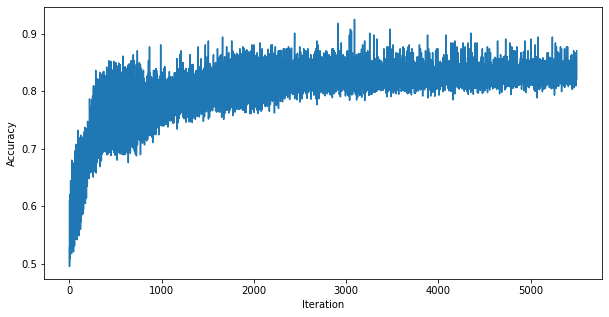

In [16]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

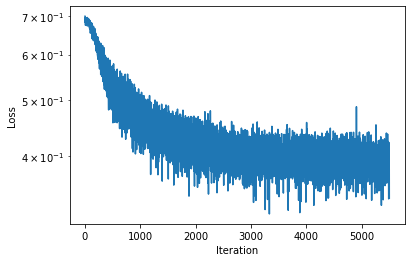

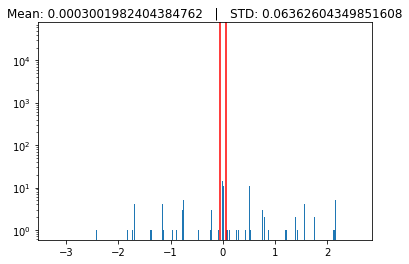

In [17]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

Average height: 5.214285714285714


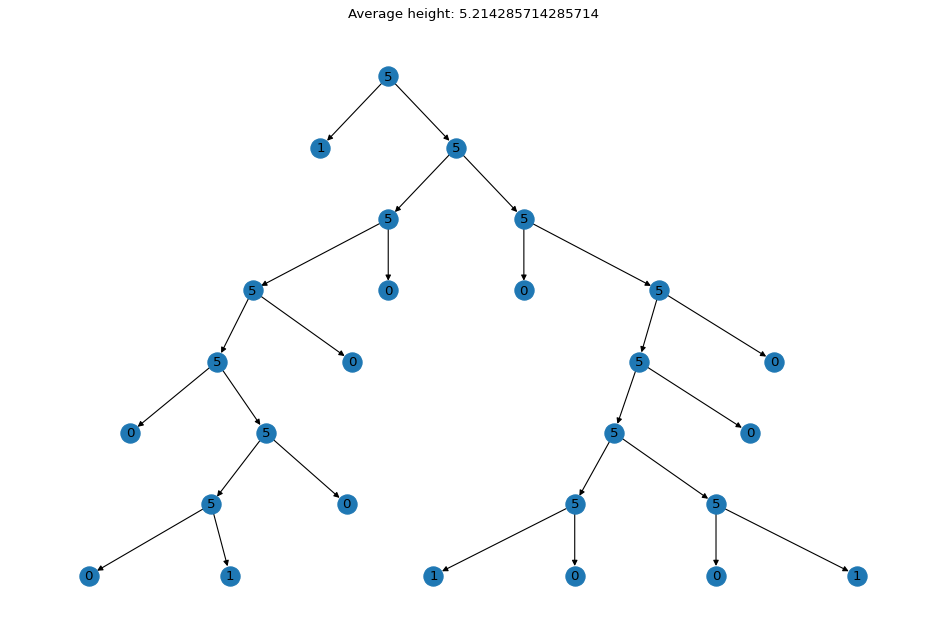

In [18]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [19]:
print(f"Number of patterns: {len(root.get_leaves())}")

Number of patterns: 14


In [20]:
method = 'MLE'

In [21]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

/home/eitan.k/.local/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Tighten boundaries

In [22]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0
comprehensibilities = []
for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    comprehensibilities.append(sum([cond.comprehensibility for cond in conds]))
    
print(f"Average comprehensibility: {np.mean(comprehensibilities)}")
print(f"std comprehensibility: {np.std(comprehensibilities)}")
print(f"var comprehensibility: {np.var(comprehensibilities)}")
print(f"minimum comprehensibility: {np.min(comprehensibilities)}")
print(f"maximum comprehensibility: {np.max(comprehensibilities)}")

============== Pattern 1 ==============
============== Pattern 2 ==============
16475
============== Pattern 3 ==============
============== Pattern 4 ==============
============== Pattern 5 ==============
============== Pattern 6 ==============
============== Pattern 7 ==============
============== Pattern 8 ==============
3818
============== Pattern 9 ==============
============== Pattern 10 ==============
============== Pattern 11 ==============
============== Pattern 12 ==============
============== Pattern 13 ==============
============== Pattern 14 ==============
Average comprehensibility: 47.714285714285715
std comprehensibility: 17.90222879750919
var comprehensibility: 320.4897959183673
minimum comprehensibility: 8
maximum comprehensibility: 66


/home/eitan.k/EntangledExplainableClustering/soft_decision_tree/sdt_model.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log(1 / (1 - x))
